In [262]:
import sys


sys.path.append('../common_code')

# # for reading datafiles 
import pandas as pd
# import script that has many standard functions:
# from PostProcessingScripts import * 

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.dates as mdates
from datetime import date
import datetime 



In [258]:
def cumhist_stop_year(data, reverse=False, mark=None, ax=None, stop_year=2024, **kwargs):
    """
    Plot a cumulative histogram of `data`, optionally with certain indices marked with an x.
    it will stop plotting at the given year 'stop_year'

    Parameters
    ----------
    data : array-like
        Data to include in the histogram
    reverse : bool, optional
        If False (default), the histogram increases with increasing `data`. If True, it decreases with increasing `data`
    mark : array-like, optional
        An array of indices to mark with an x
    ax : matplotlib.pyplot.axes, optional
        Axis on which to plot the confusion matrix. Default: current axis.
    kwargs : dict, optional
        Keyword arguments to be passed to `matplotlib.pyplot.step`

    Returns
    -------
    p : list
        The list of `matplotlib.lines.Line2D` objects returned by `matplotlib.pyplot.step`
    """
    
    if mark is None:
        mark = np.zeros(len(data), bool)
    if ax is None:
        ax = plt.gca()
    i = np.argsort(data)
    x = data[i]
    
    # only plot until given stop_year value
    mask_stop_year = data[i]< stop_year
    mark = mark[i]
    
    if np.sum(mask_stop_year)>=1:
        x = np.append(x[mask_stop_year], x[mask_stop_year][-1])
        y = np.linspace(0., x.size-1, x.size) 
        if reverse:
            y = y[::-1]
            
        ax.step(x, y, **kwargs)
        y_max = y[-1] 
        
        # add a horizontal line to draw detections until time plotted (otherwise it only updates when a new detection happens) 
        
        min_stop = min(stop_year, O4begin)
        ax.plot([x[-1], min_stop], [y[-1], y[-1]], **kwargs)
        
        
        
    else:
        y_max=0
        
    
    return y_max
 



def cumhist(data, reverse=False, mark=None, ax=None, **kwargs):
    """
    Plot a cumulative histogram of `data`, optionally with certain indices marked with an x.

    Parameters
    ----------
    data : array-like
        Data to include in the histogram
    reverse : bool, optional
        If False (default), the histogram increases with increasing `data`. If True, it decreases with increasing `data`
    mark : array-like, optional
        An array of indices to mark with an x
    ax : matplotlib.pyplot.axes, optional
        Axis on which to plot the confusion matrix. Default: current axis.
    kwargs : dict, optional
        Keyword arguments to be passed to `matplotlib.pyplot.step`

    Returns
    -------
    p : list
        The list of `matplotlib.lines.Line2D` objects returned by `matplotlib.pyplot.step`
    """
    if mark is None:
        mark = np.zeros(len(data), bool)
    if ax is None:
        ax = plt.gca()
    i = np.argsort(data)
    x = data[i]
    mark = mark[i]
    x = np.append(x, x[-1])
    y = np.linspace(0., x.size, x.size) -1
    if reverse:
        y = y[::-1]
    p = ax.step(x, y, **kwargs)
    ax.scatter(data[i][mark], (y[:-1] + 0.5 * np.diff(y))[mark], marker='x')
    return p






def find_position_plot(year):
    
    position  = (year-2014)/(2040-2014)
    return position



def plot_detector_labels(axe):
    labels = [r'$\textbf{O1}$', r'$\textbf{O2}$', r'$\textbf{O3}$',  r'$\textbf{O4}$',  r'$\textbf{O5}$',  r'$\textbf{Voyager}$',   r'$\textbf{CE/ET}$'] # r'$\textbf{next-gen:}$' +'\n' + r'$\textbf{CE/ET}$' ]
    label_centers = [2015.9, 2017.35, 2019.78, 2024.26, 2027, 2032., 2037.3]
    for ind_year, year in enumerate(label_centers):
        position = find_position_plot(year)
        axe.text(position, 1-0.009, labels[ind_year] , rotation = 0, fontsize = fs+10, color = 'k', ha = 'center', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')



        
def strip_GW_from_GW_in_name(GW_events_list):
    fmt = 'GW%y%m%d'
    """ strip GWnames of the 'GW' in front of label and determine datetime of events"""
    GW_events_list_stripped = np.zeros_like(GW_events_list)

    for ind_GW, GWlist in enumerate(GW_events_list):
        
        d2 = GWlist.split('_')[0]
        GW_events_list_stripped[ind_GW] = d2
        
    return GW_events_list_stripped



def obtain_GW_datetimes(GW_events_list):
    fmt = 'GW%y%m%d'
    """ strip GWnames of the 'GW' in front of label and determine datetime of events"""
    GW_events_list_datetimes = GW_events_list
    # iterate over DCO flavors
    for ind_DCO, GWlist in enumerate(GW_events_list):
        strp_ = []
        for GW_ in GWlist:
            d2 = datetime.datetime.strptime(GW_.split('_')[0], fmt)
            
            
            d0 = date(d2.year, 1, 1) # first day of the year of the event
            delta_days_since_d0 = date(d2.year, d2.month, d2.day) - d0
            fraction_year = delta_days_since_d0/((date(d2.year+1, 1, 1) - d0))
            d2 = d2.year + fraction_year  # this adjusts for leap years etc. 
            strp_.append(d2)  
            
        GW_events_list_datetimes[ind_DCO] = strp_
        
    return GW_events_list_datetimes




def create_GW_list_from_data(label_dataset='GWTC3_pop', threshold_mass_NS = 2.5, print_output=False):
    """
    threshold_mass_NS = 2.5 [Msun] # threshold mass below which compact object is NS based on GW median posterior mass 
    label_dataset options: ['GWTC3_pop_far<0_25yr', 'GWTC3_pop_far<1yr', 'GWOSC', ]
    """
        
    if label_dataset in ['GWTC3_pop_far<0_25yr', 'GWTC3_pop_far<1yr']:
        # data based on catalog definition: 
        file_name = 'gwtc-3_pop_events_table_1.csv'
        header_GW_name = 'Event name'
        
    elif label_dataset in ['GWOSC', 'GWOSC_plus_external']:
        # data from the GWOSC, downloaded from the csv file at https://www.gw-openscience.org/eventapi/html/GWTC/ 
        file_name = 'GWOSC_events.csv'
        header_GW_name = 'commonName'
        
    elif label_dataset in ['4-OGC']:
        file_name = '4OGC_top_events_final_final_final.csv'
        header_GW_name = 'commonName'
    
    # read in the GW detections names from csv catalog file
    df = pd.read_csv('./GWcatalogData/'+file_name, encoding='latin-1')
    GWnames = df[header_GW_name]
    mass_1_source, mass_2_source = df['mass_1_source'], df['mass_2_source']

    mask_mass_1_NS, mask_mass_2_NS = (mass_1_source <= 2.5), (mass_2_source <= 2.5)
    
    BBH_list = GWnames[(mass_1_source > threshold_mass_NS)&(mass_2_source > threshold_mass_NS)].to_numpy()
    BHNS_list = GWnames[((mass_1_source > threshold_mass_NS)&(mass_2_source <= threshold_mass_NS)) | ((mass_1_source <= threshold_mass_NS)&(mass_2_source > threshold_mass_NS))].to_numpy()
    BNS_list = GWnames[(mass_1_source <= threshold_mass_NS)&(mass_2_source <= threshold_mass_NS)].to_numpy()
    
    
    if label_dataset ==  'GWTC3_pop_far<0_25yr':
        # remove events that have 1 >= FAR >= 0.25 yr^-1
        FAR_min = df['FAR_min']
        mask_too_high_FAR = (FAR_min>=0.25)
        
        BBH_list = GWnames[(mass_1_source > threshold_mass_NS)&(mass_2_source > threshold_mass_NS) & (mask_too_high_FAR==0)]
        BHNS_list = GWnames[((mass_1_source > threshold_mass_NS)&(mass_2_source <= threshold_mass_NS)& (mask_too_high_FAR==0)) | ((mass_1_source <= threshold_mass_NS)&(mass_2_source > threshold_mass_NS)& (mask_too_high_FAR==0))]
        BNS_list = GWnames[(mass_1_source <= threshold_mass_NS)&(mass_2_source <= threshold_mass_NS)& (mask_too_high_FAR==0)]            

    elif label_dataset=='GWOSC_plus_external':
        # extra events from 
        # O1 extra events: ['GW151216'], from https://arxiv.org/pdf/1902.10331.pdf, but removed in OGC-4, so not included 
        # O2 extra events: [GW170121, GW170304, GW170727] # https://arxiv.org/pdf/1904.07214.pdf : O2 extra events based on  including 14 BBH mergers with pastro >0.5 https://arxiv.org/pdf/1910.05331.pdf, 
        # O2 extra events GW170425, GW170202, and GW170403, with lower p_astro (but still in between 0.5-0.8 from https://arxiv.org/pdf/1904.07214.pdf ) and confirmed in https://arxiv.org/pdf/1910.05331.pdf albeit with lower p_astro
        # O3 exrta events: GW191224 043228, GW200106 134123, GW200129 114245, GW200210 005122, GW200214 223307, GW200305 084739, and GW200318 ] based on https://arxiv.org/pdf/2112.06878.pdf OGSS-4
        # GW170816 ='GW170817A', but I dont have a better way to count double events (ie happening at the same day) at this time, so hence the hack . found by https://arxiv.org/abs/1910.09528 they also found GWC170402
        external_found_BBHs_list = np.asarray(['GW151216', 'GW170121', 'GW170304', 'GW170727', 'GW170425', 'GW170202', 'GW170403', 'GW191224', 'GW200106','GW200129', 'GW200210', 'GW200214', 'GW200305', 'GW200318', 'GW170816'])
        
        
        # BBH_list has GWOSC events, add the externally found events
        BBH_list = np.concatenate((BBH_list, external_found_BBHs_list))
        
        #get 4-OGC events:
        file_name = '4OGC_top_events_final_final_final.csv'
        header_GW_name = 'commonName'
        df = pd.read_csv('./GWcatalogData/'+file_name, encoding='latin-1')
        GWnames = df[header_GW_name]
        mass_1_source, mass_2_source = df['mass_1_source'], df['mass_2_source']
        mask_mass_1_NS, mask_mass_2_NS = (mass_1_source <= 2.5), (mass_2_source <= 2.5)
        
        #add 4-OGC events, strip all events from 'GW' and find unique set of events (since indepdent catalogs overlap), then sort them by time
        BBH_list = np.sort(np.unique(strip_GW_from_name(np.concatenate((BBH_list, GWnames[(mass_1_source > threshold_mass_NS)&(mass_2_source > threshold_mass_NS)].to_numpy())))))
        
        BHNS_4OGC = GWnames[((mass_1_source > threshold_mass_NS)&(mass_2_source <= threshold_mass_NS)) | ((mass_1_source <= threshold_mass_NS)&(mass_2_source > threshold_mass_NS))].to_numpy()
        BHNS_list = np.sort(np.unique(strip_GW_from_GW_in_name(np.concatenate((BHNS_list, BHNS_4OGC)))))
        BNS_list = np.sort(np.unique(strip_GW_from_GW_in_name(np.concatenate((BNS_list, GWnames[(mass_1_source <= threshold_mass_NS)&(mass_2_source <= threshold_mass_NS)].to_numpy())))))
    
    
    GW_events_list = [BBH_list, BHNS_list, BNS_list]
    
    if print_output==True:
        print('counting O1+O2+O3: total = %s,  %s BBHs, %s BHNSs, %s BNSs'%(len(BBH_list)+len(BHNS_list)+len(BNS_list), len(BBH_list), len(BHNS_list), len(BNS_list)), 'for %s'%label_dataset)
    
    return GW_events_list




def plot_detector_labels_O4(axe):
    labels = [r'$\textbf{O1}$', r'$\textbf{O2}$', r'$\textbf{O3}$',  r'$\textbf{O4}$']#,  r'$\textbf{O5}$',  r'$\textbf{Voyager}$',   r'$\textbf{CE/ET}$'] # r'$\textbf{next-gen:}$' +'\n' + r'$\textbf{CE/ET}$' ]
    label_centers = [2015.9, 2017.3, 2019.78, 2024.26]
    for ind_year, year in enumerate(label_centers):
        axe.annotate(labels[ind_year], (year, 1-0.129), xycoords=('data','figure fraction'),  rotation = 0, fontsize = fs+10, color = 'k', ha = 'center', va='top', zorder=100)

        
    return 

def make_cumhist_past_detections(ax, detectionlist, y_max_all, stop_year, DCOcolors, **kwargs):
    #### plots cumhist of past detections up to min(stop_year, O4begin) #####
    for ind_DCO, DCOdetections in enumerate(detectionlist):
        y_max = cumhist_stop_year(data=np.asarray(DCOdetections), ax=ax, c=DCOcolors[ind_DCO], stop_year=stop_year, **kwargs)
        y_max_all.append(y_max)


        # annotate labels for BHBH, BHNS, BNS
        if stop_year<2021:
            if ind_DCO==0:
                axe.annotate(r'$\textbf{BH-BH: } %s$'%int(y_max), (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
            if ind_DCO==1:
                axe.annotate(r'$\textbf{BH-NS: } %s$'%int(y_max), (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
            if ind_DCO==2:
                axe.annotate(r'$\textbf{NS-NS: } %s$'%int(y_max), (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )

    return y_max_all








# obtain a list with GW events for all three flavors for each catalog 
GW_events_list = create_GW_list_from_data(label_dataset='GWOSC', print_output=True)    
GW_events_list = create_GW_list_from_data(label_dataset='GWTC3_pop_far<0_25yr', print_output=True) 
GW_events_list = create_GW_list_from_data(label_dataset='GWTC3_pop_far<1yr', print_output=True)  
GW_events_list = create_GW_list_from_data(label_dataset='4-OGC', print_output=True) 
GW_events_list = create_GW_list_from_data(label_dataset='GWOSC_plus_external', print_output=True) 



counting O1+O2+O3: total = 90,  85 BBHs, 3 BHNSs, 2 BNSs for GWOSC
counting O1+O2+O3: total = 67,  63 BBHs, 2 BHNSs, 2 BNSs for GWTC3_pop_far<0_25yr
counting O1+O2+O3: total = 76,  70 BBHs, 4 BHNSs, 2 BNSs for GWTC3_pop_far<1yr
counting O1+O2+O3: total = 94,  90 BBHs, 2 BHNSs, 2 BNSs for 4-OGC
counting O1+O2+O3: total = 101,  95 BBHs, 4 BHNSs, 2 BNSs for GWOSC_plus_external


In [224]:
datetime_today = datetime.datetime.now()
datetime_today_perc = datetime_today.year + datetime_today.day/365.


# days passed since beginning of year
d0 = date(2023, 1, 1)
d1 = date(2023, 5, 24) # 24 may = begin O4 
delta = d1 - d0
# calculate days until O4
d0 = date(datetime_today.year, datetime_today.month, datetime_today.day)
d1 = date(2023, 5, 24) # 24 may = begin O4 
delta_O4 = d1 - d0
print(delta_O4.days, 'days to O4')


def calculate_fraction_days_year(d0_year=2023, d1=date(datetime_today.year, datetime_today.month, datetime_today.day)):
    d0 = date(d0_year, 1, 1) # first day of the year 
    delta_days_since_2023 = d1 - d0
    fraction_year = delta_days_since_2023/((date(d0_year+1, 1, 1) - d0))
    return d0_year + fraction_year
    
    

# define beginning and end dates of observing runs 
O1begin = calculate_fraction_days_year(d0_year=2015, d1=date(2015, 9, 12)) # 12 september 2015
O1end   = calculate_fraction_days_year(d0_year=2016, d1=date(2016, 1, 19)) # 19 Jan 2016
O2begin = calculate_fraction_days_year(d0_year=2016, d1=date(2016, 11, 30)) # nov 30 2016
O2end   = calculate_fraction_days_year(d0_year=2017, d1=date(2017, 8, 25))  # aug 25 2017
O3begin = calculate_fraction_days_year(d0_year=2019, d1=date(2019, 4, 1)) # 1 april 2019
O3end   = calculate_fraction_days_year(d0_year=2020, d1=date(2020, 3, 27)) # 27 march 2020
O4begin = calculate_fraction_days_year(d0_year=2023, d1=date(2023, 5, 24)) # 24 may 2023
O4end   = calculate_fraction_days_year(d0_year=2025, d1=date(2025, 1, 31)) # 31 january 2025 (about ~18 months later)
O5begin = 2026
O5end = 2028
Voy_begin = 2030
Voy_end = 2034
ET_CEbegin = 2035
ET_CEend = 2040

dates = [O3end, O4begin, O4end, O5begin, O5end, Voy_begin, Voy_end, ET_CEbegin, ET_CEend]
all_dates = [O1begin, O1end, O2begin, O2end, O3begin, O3end, O4begin, O4end, O5begin, O5end, Voy_begin, Voy_end, ET_CEbegin, ET_CEend]





55 days to O4


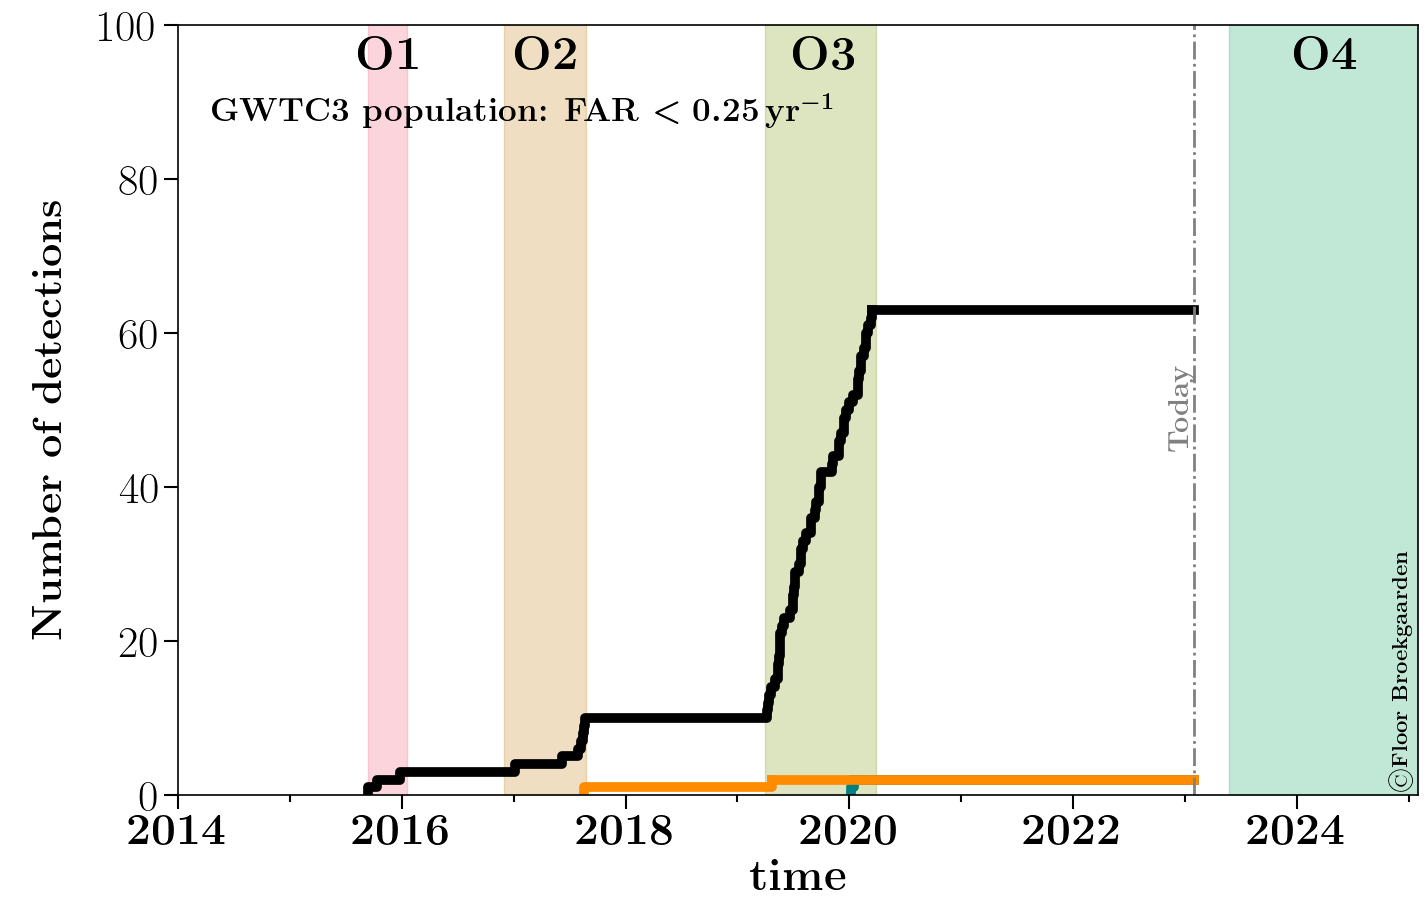

counting O1+O2+O3: total = 76,  70 BBHs, 4 BHNSs, 2 BNSs for GWTC3_pop_far<1yr
[array(['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608',
       'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823',
       'GW190408_181802', 'GW190412_053044', 'GW190413_052954',
       'GW190413_134308', 'GW190421_213856', 'GW190503_185404',
       'GW190512_180714', 'GW190513_205428', 'GW190517_055101',
       'GW190519_153544', 'GW190521_030229', 'GW190521_074359',
       'GW190527_092055', 'GW190602_175927', 'GW190620_030421',
       'GW190630_185205', 'GW190701_203306', 'GW190706_222641',
       'GW190707_093326', 'GW190708_232457', 'GW190719_215514',
       'GW190720_000836', 'GW190725_174728', 'GW190727_060333',
       'GW190728_064510', 'GW190731_140936', 'GW190803_022701',
       'GW190805_211137', 'GW190814_211039', 'GW190828_063405',
       'GW190828_065509', 'GW190910_112807', 'GW190915_235702',
       'GW190924_021846', 'GW190925_232845', 'GW190929_012149',
       'GW190930_1

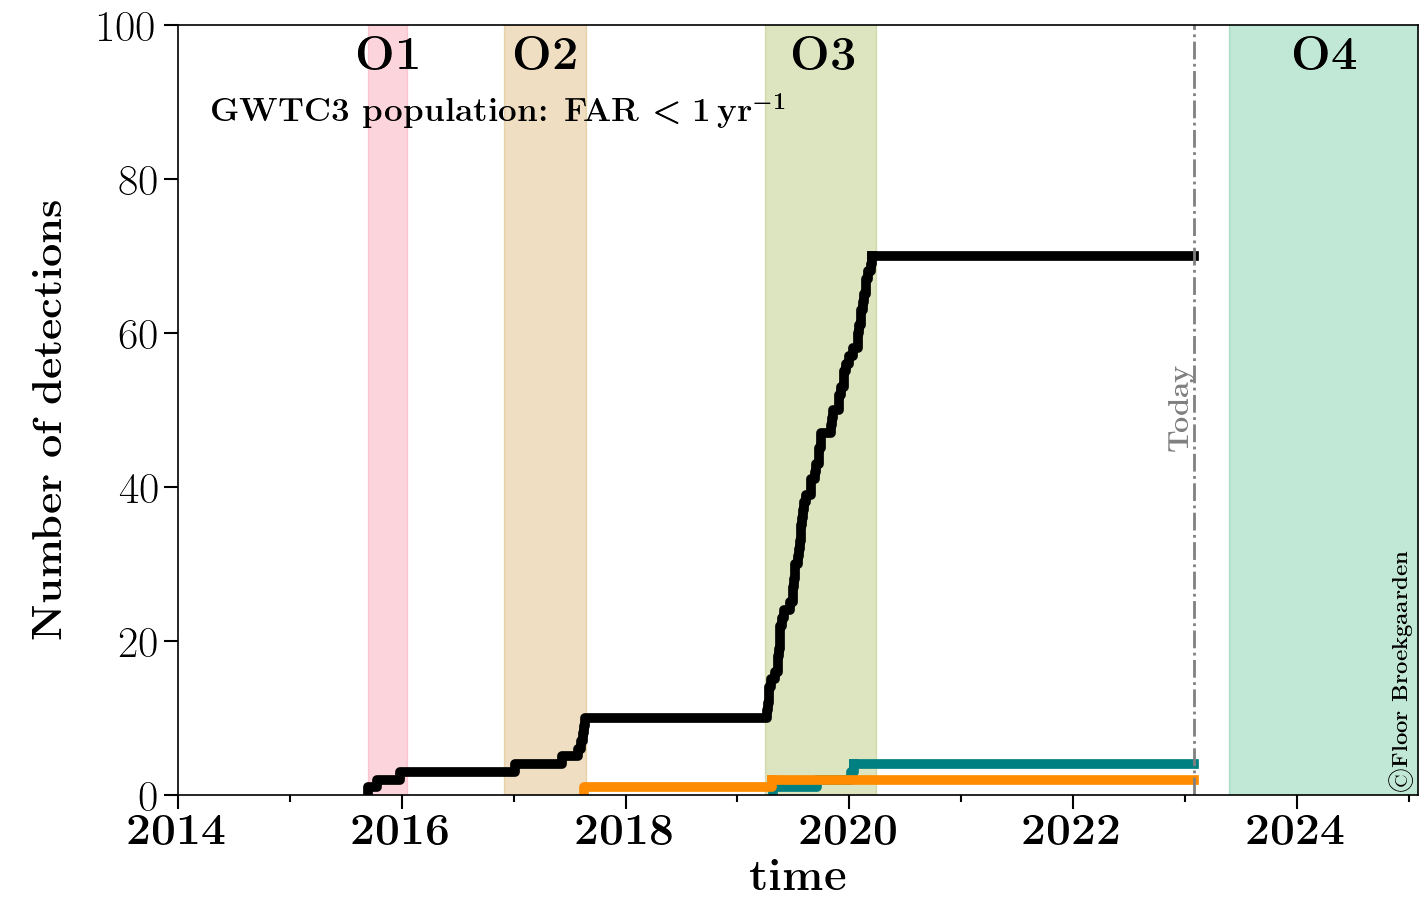

counting O1+O2+O3: total = 90,  85 BBHs, 3 BHNSs, 2 BNSs for GWOSC
[array(['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608',
       'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823',
       'GW190403_051519', 'GW190408_181802', 'GW190412',
       'GW190413_052954', 'GW190413_134308', 'GW190421_213856',
       'GW190426_190642', 'GW190503_185404', 'GW190512_180714',
       'GW190513_205428', 'GW190514_065416', 'GW190517_055101',
       'GW190519_153544', 'GW190521', 'GW190521_074359',
       'GW190527_092055', 'GW190602_175927', 'GW190620_030421',
       'GW190630_185205', 'GW190701_203306', 'GW190706_222641',
       'GW190707_093326', 'GW190708_232457', 'GW190719_215514',
       'GW190720_000836', 'GW190725_174728', 'GW190727_060333',
       'GW190728_064510', 'GW190731_140936', 'GW190803_022701',
       'GW190805_211137', 'GW190814', 'GW190828_063405',
       'GW190828_065509', 'GW190910_112807', 'GW190915_235702',
       'GW190916_200658', 'GW190924_021846', 'GW190

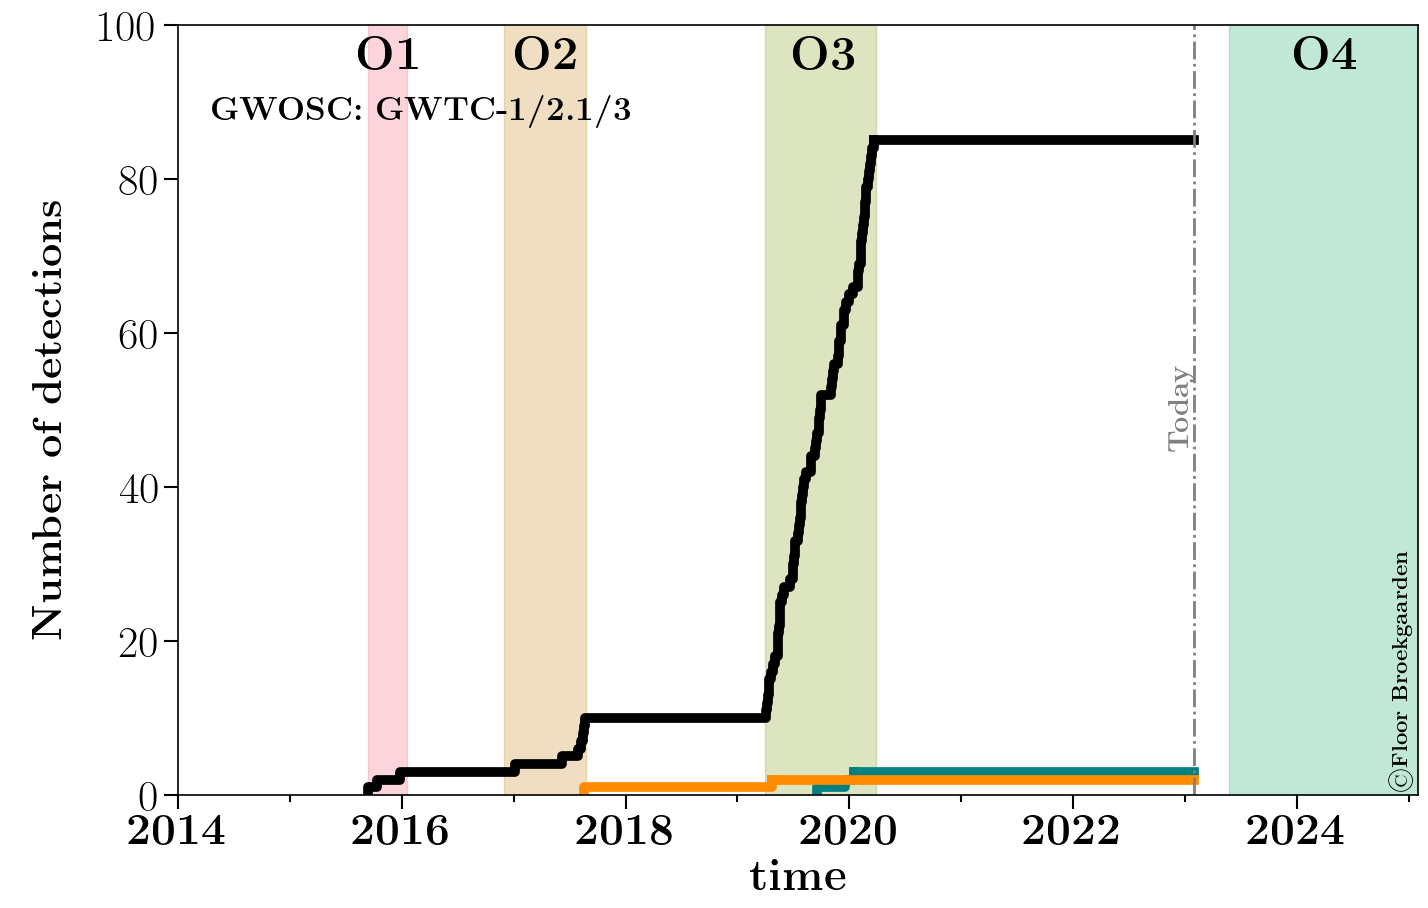

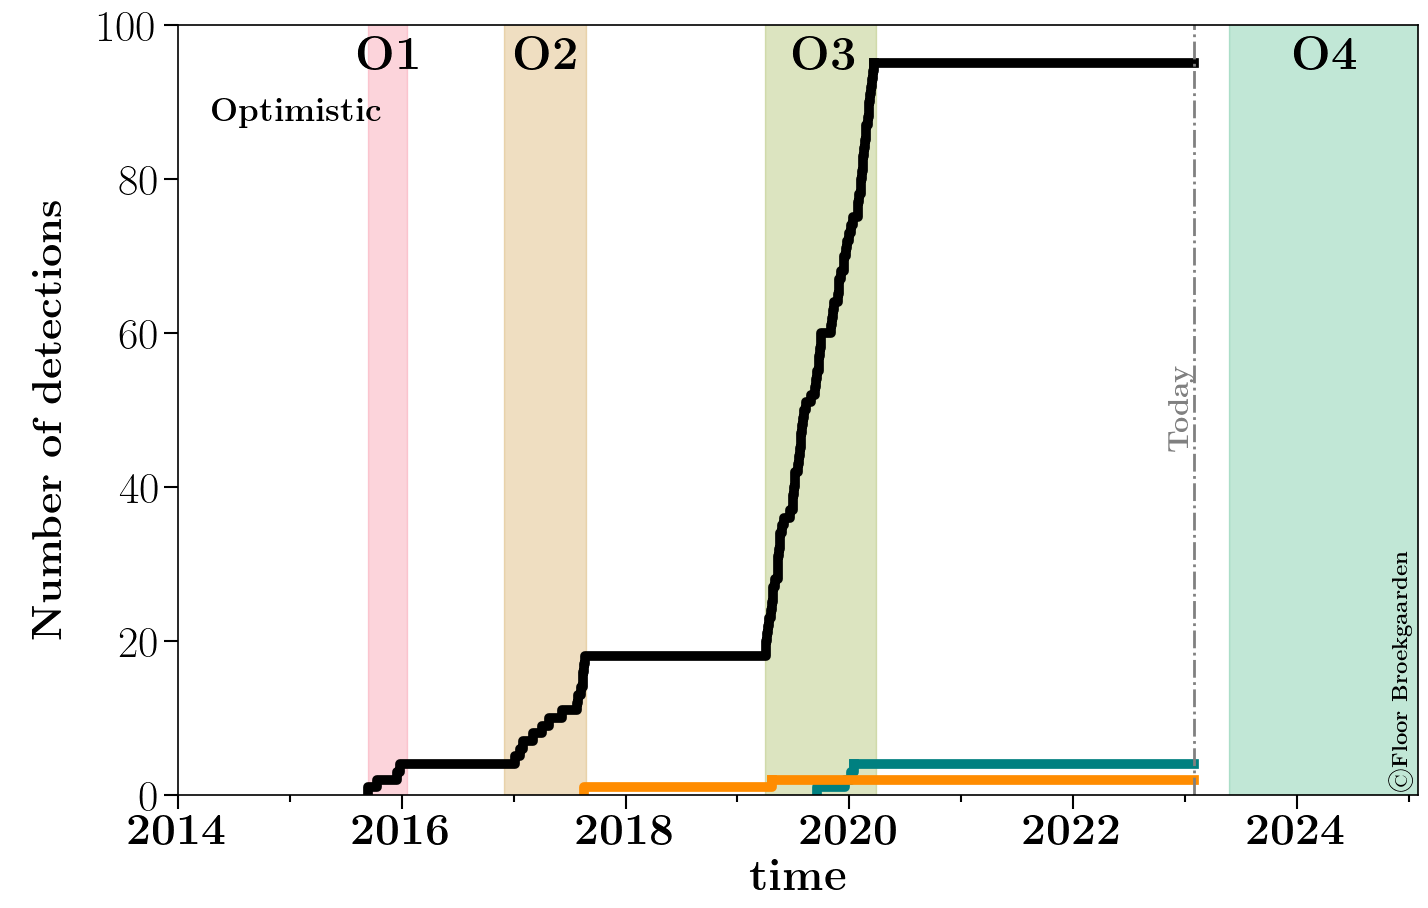

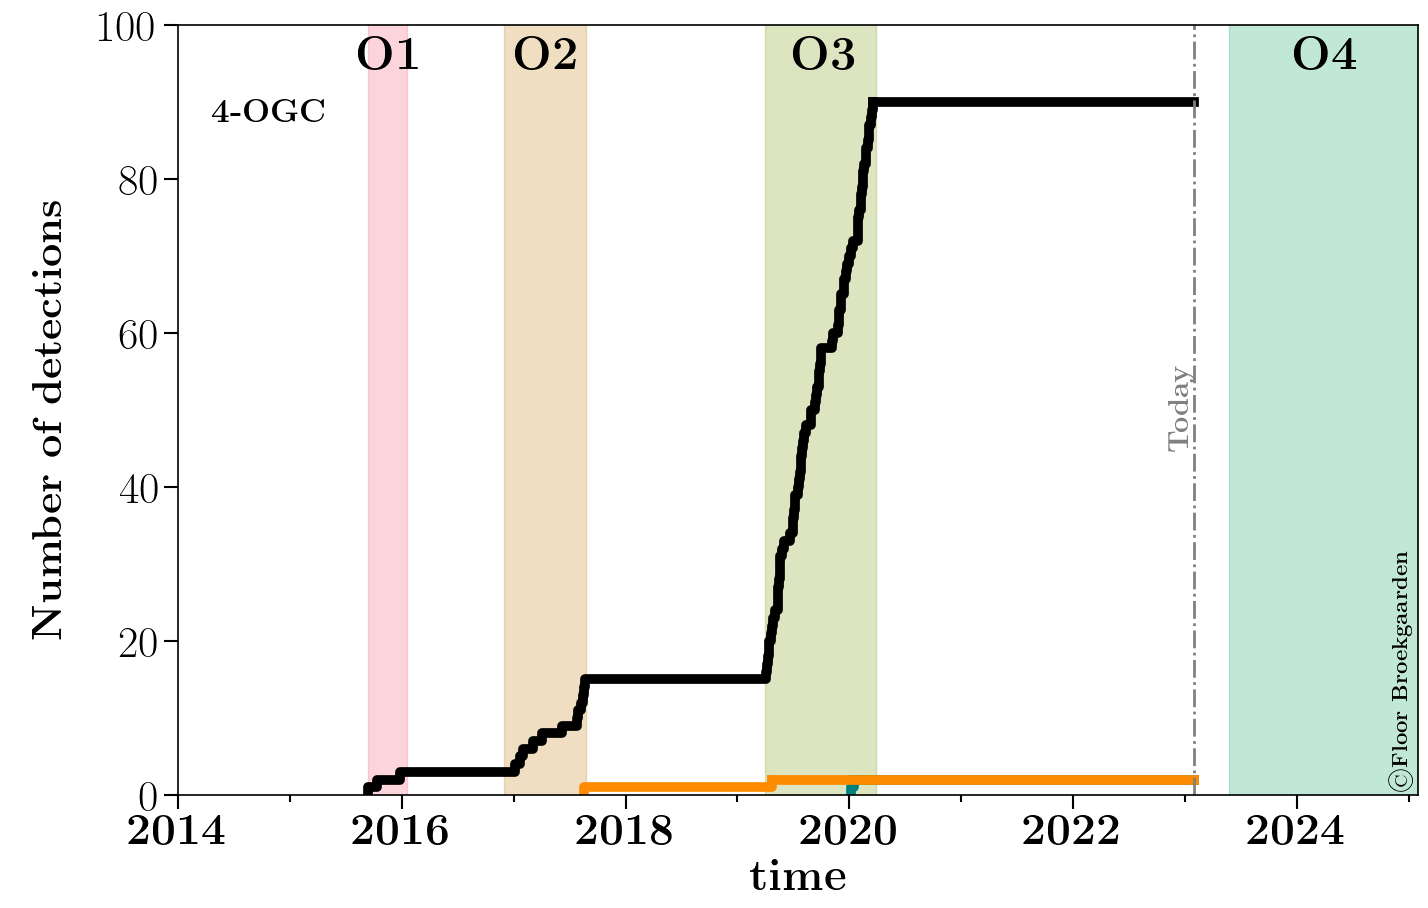

In [230]:



def make_figures_different_GWTC3_catalog(label_dataset='GWTC3_pop_far<0_25yr', label='GWTC3 FAR > 0.25 $\rm{yr}^{-1}$', no_label=0, print_output=False):


    making_movie=False
    DCOcolors = ['k',  'teal', 'darkorange']  


    
    GW_events_list = create_GW_list_from_data(label_dataset=label_dataset, print_output=print_output)
    if print_output==True:
        print(GW_events_list )
    detectionlist = obtain_GW_datetimes(GW_events_list) 

    if making_movie:
        total = 400 
        folder_save = './GWcatalogMovie'
        enumerate_list = np.linspace(2015, datetime_today, total)
    else:
        folder_save = './GWcatalogFigures'
        enumerate_list = [datetime_today_perc]


    for ind_sy, stop_year in enumerate(enumerate_list):
        f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))

#         if print_output:
#              print('at figure %s out of %s. Stopping this plot at year %s'%(ind_sy+1, total, stop_year))
        y_max_all = []

        #### plots cumhist of past detections up to min(stop_year, O4begin) #####
        y_max_all = make_cumhist_past_detections(ax=axe, detectionlist=detectionlist, y_max_all=y_max_all, stop_year=stop_year, DCOcolors=DCOcolors, lw=7) 
        
        
        mask_stop_year = np.asarray(dates[:-1])< stop_year

        if np.sum(mask_stop_year)>=1:
            items_ind = len(np.asarray(dates[:-1])[mask_stop_year])
            for ind_d, line in enumerate(np.asarray(dates[:-1])[mask_stop_year]):
                continue 

        # update the max y-value, to scale the y-axis later 
        maxx_ = np.max(y_max_all)
        max_yvalue = np.max([5, maxx_])

        # fill between detector runs
        for ind_d, line in enumerate(all_dates[:-1]):
            if (ind_d%2)==0:
                axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.00, 0.00], y2=[10.5*max_yvalue,10.5*max_yvalue], alpha=0.3, color=colors[ind_d], zorder=0)

        ###### SHOW TODAY ########
        # uncomment the following four lines if you want to print a vertical line that shows where "today" is  
        x_today = np.linspace(datetime_today_perc, datetime_today_perc, 100)
        y_today = np.linspace(0, 5*1E6, 100)
        axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
        axe.annotate(r'$\textbf{Today}$', (datetime_today_perc,0.5), xycoords=('data','figure fraction'),  fontsize=fs-3, rotation=90, ha='right', va='center', color='gray' )
        ###############

#         axe.set_ylim(0,1.1*max_yvalue) 
        axe.set_ylim(0,100)
        if stop_year<=2035:
            axe.yaxis.set_major_formatter('{x:,.0f}')
        else:
            axe.yaxis.set_major_formatter('{x:2,.0f}')

        # set up axis ticks 
        axe.xaxis.set_major_locator(plt.MultipleLocator(2))
        axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
        axe.set_xlim(2014, O4end)

        # plot the GW detector labels in the top
        plot_detector_labels_O4(axe=axe)

        xlabel =  r'\textbf{time}'
        axe = layoutAxes(axe, nameX=xlabel, nameY=None, setMinor=False, fontsize=fs+8)


        # add y-label, have to use annotate since otherwise alignment between frames is messed up 
        axe.annotate(r'$\textbf{Number of detections}$', (0.02,0.49), xycoords=('figure fraction','figure fraction'),  fontsize=fs+6, rotation=90, ha='left', va='center', color='k' )
    #     ylabel = r'\textbf{Number of detections}' # original ylabel name         



        # add credits 
        axe.annotate(r'$\copyright \textbf{Floor Broekgaarden}$', (0.883,0.116), xycoords=('figure fraction','figure fraction'),  fontsize=fs-8, rotation=90, ha='right', va='bottom', color='k' )
        
        # which GWTC3 catalog 
        axe.annotate(r'$\textbf{%s }$'%label, (2014.3,0.78), xycoords=('data','figure fraction'),  fontsize=fs, rotation=0, ha='left', va='bottom', color='k' )
        
        # save to directory for making movie later. 
        if making_movie:
            plt.savefig(folder_save+'/knownDetectionsGWcatalogSize_%s.png'%ind_sy, dpi=100, transparent=False)
        
        else:
            plt.savefig(folder_save+'/knownDetectionsGWcatalogSize_%s.png'%no_label, dpi=100, transparent=False)
            
        plt.show() # this will create a *lot* of figures 
        plt.close()

make_figures_different_GWTC3_catalog(label_dataset='GWTC3_pop_far<0_25yr', label=r'GWTC3 population: FAR $< 0.25\, \rm{yr}^{-1}$', no_label=0)
make_figures_different_GWTC3_catalog(label_dataset='GWTC3_pop_far<1yr', label=r'GWTC3 population: FAR $< 1\, \rm{yr}^{-1}$', no_label=1, print_output=True)
make_figures_different_GWTC3_catalog(label_dataset='GWOSC', label=r'GWOSC: GWTC-1/2.1/3', no_label=2, print_output=True)
make_figures_different_GWTC3_catalog(label_dataset='GWOSC_plus_external', label=r'Optimistic', no_label=3)
make_figures_different_GWTC3_catalog(label_dataset='4-OGC', label=r'4-OGC', no_label=3)



In [226]:




def make_figures_different_GWTC3_catalog(axe, label_dataset='GWTC3_pop_far<0_25yr', label='GWTC3 FAR > 0.25 $\rm{yr}^{-1}$', no_label=0, enumerate_list=['0'], print_output=False):

    
    
    
    datasets = [ 'GWOSC_plus_external', '4-OGC', 'GWOSC', 'GWTC3_pop_far<1yr', 'GWTC3_pop_far<0_25yr']
    datasets_labels = [ r'$\textbf{Optimistic}$', r'$\textbf{4-OGC}$' , r'$\textbf{GWOSC (GWTC-1/2.1/3)}$',  r'$\textbf{GWTC3 pop} < 1 \rm{yr}^{-1}$ ' ,  r'$\textbf{GWTC3 pop} < 0.25 \rm{yr}^{-1}$ ' ]
    datasets_number_loc = [0.52, 0.47, 0.42, 0.37, 0.32]
    making_movie=False
    DCOcolors = ['k',  'teal', 'darkorange']  
    datasets_ls = ['-', ':', '-.', '--', '--']

    
    for ind_sy, stop_year in enumerate(enumerate_list):
        

        if print_output==True:
            print('at figure %s out of %s. Stopping this plot at year %s'%(ind_sy+1, total, stop_year))
        y_max_all = []
        
        
        for ind_dataset, label_dataset in enumerate(datasets):
            GW_events_list = create_GW_list_from_data(label_dataset=label_dataset)
            detectionlist = obtain_GW_datetimes(GW_events_list) 


            for ind_DCO, DCOdetections in enumerate(detectionlist):
                y_max = cumhist_stop_year(data=np.asarray(DCOdetections), ax=axe, c=DCOcolors[ind_DCO], lw=3, stop_year=stop_year, ls=datasets_ls[ind_dataset])
                y_max_all.append(y_max)


#               annotate labels for BHBH, BHNS, BNS
#                 if stop_year<2021:
                if ind_DCO==0:
                    axe.annotate(datasets_labels[ind_dataset], (2021.9, datasets_number_loc[ind_dataset]), xycoords=('data','figure fraction'),  fontsize=fs-7, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
                    axe.annotate(r'$%s$'%int(y_max), (2020.5, datasets_number_loc[ind_dataset]), xycoords=('data','figure fraction'),  fontsize=fs, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
                if ind_DCO==1:
                    axe.annotate(r'$%s$'%int(y_max), (2021.16, datasets_number_loc[ind_dataset]), xycoords=('data','figure fraction'),  fontsize=fs, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
                if ind_DCO==2:
                    axe.annotate(r'$%s$'%int(y_max), (2021.5, datasets_number_loc[ind_dataset]), xycoords=('data','figure fraction'),  fontsize=fs, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )


            # update the max y-value, to scale the y-axis later 
            max_yvalue = np.max([5, np.max(y_max_all)])

    return

  

#### start making video by making 'total' number of frames over time 

total = 400 
folder_save = './GWcatalogMovie'
movie_list = np.linspace(2015, 2025.05, total)    

for ind_m, enumerate_list in enumerate(movie_list ):  

        
    f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))

    # fill between detector runs
    for ind_d, line in enumerate(all_dates[:-1]):
        if (ind_d%2)==0:
            axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.00, 0.00], y2=[10.5*200,10.5*200], alpha=0.3, color=colors[ind_d], zorder=0)

    ###### SHOW TODAY ########
    # # uncomment the following four lines if you want to print a vertical line that shows where "today" is  
    # x_today = np.linspace(datetime_today_perc, datetime_today_perc, 100)
    # y_today = np.linspace(0, 5*1E6, 100)
    # axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
    # axe.annotate(r'$\textbf{Today}$', (datetime_today_perc,0.6), xycoords=('data','figure fraction'),  fontsize=fs-3, rotation=90, ha='right', va='center', color='gray' )
    # ###############

    axe.set_ylim(0,104)

    # set up axis ticks 
    axe.xaxis.set_major_locator(plt.MultipleLocator(2))
    axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
    axe.set_xlim(2014, 2025.05)

    # plot the GW detector labels in the top
    plot_detector_labels_O4(axe=axe)
    
    # set labels 
    xlabel =  r'\textbf{time}'
    axe = layoutAxes(axe, nameX=xlabel, nameY=None, setMinor=False, fontsize=fs+8)
    axe.annotate(r'$\textbf{Number of detections}$', (0.02,0.49), xycoords=('figure fraction','figure fraction'),  fontsize=fs+6, rotation=90, ha='left', va='center', color='k' ) ## add y-label, have to use annotate since otherwise alignment between frames might be messed up 

    # add credits 
    axe.annotate(r'$\copyright \textbf{Floor Broekgaarden}$', (0.9,0.116), xycoords=('figure fraction','figure fraction'),  fontsize=fs-8, rotation=90, ha='right', va='bottom', color='k' )

    # annotate labels for BHBH, BHNS, BNS
    DCOcolors = ['k',  'teal', 'darkorange']  
    axe.annotate(r'$\textbf{BH-BH}$', (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
    axe.annotate(r'$\textbf{BH-NS}$', (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
    axe.annotate(r'$\textbf{NS-NS}$', (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )

    make_figures_different_GWTC3_catalog(axe,label_dataset='GWTC3_pop_far<0_25yr', label=r'GWTC3 population: FAR $< 0.25\, \rm{yr}^{-1}$', no_label=0, enumerate_list=[enumerate_list])
    plt.savefig(folder_save+'/knownDetectionsGWcatalogSizeMovie_%s.png'%ind_m, dpi=100, transparent=False)
#     plt.show() # this will create a *lot* of figures 
    plt.close()
    
print('done!')




done!


# make one figure with the uncertainties and a specific date  (used for PhD thesis) 


In [235]:

# # choose which one to start with 
# label_dataset = 'GWOSC'
# print_output=False
# GW_events_list = create_GW_list_from_data(label_dataset=label_dataset, print_output=print_output)
# if print_output==True:
#     print(GW_events_list )
# detectionlist = obtain_GW_datetimes(GW_events_list) 



# ## BBH 
# n_O4 = 230
# numberO3end = len(detectionlist[0]) # number BBHs at end of O3
# numberO4end = numberO3end + n_O4 # O4 has about twice as many BBHs as O3  (180 = 2x90)
# numberO5end = numberO4end + 4*n_O4 # O5 has about twice as many BBHs as O3  (180 = 2x90)
# numbersVoyend = numberO5end + 50*n_O4 # based on the factor 100 compared to O3, from https://arxiv.org/pdf/2001.11173.pdf  (which is a factor 50 compared to O4)
# numbersCEend = numbersVoyend + 69799  * 5 # CE will detect about 60 000 events BBH per year, see https://arxiv.org/abs/2207.02771 , factor 5 for the timeline (that is already included in the other ones)
# numbers_BBH = [numberO3end, numberO3end, numberO4end, numberO4end, numberO5end, numberO5end, numbersVoyend, numbersVoyend, numbersCEend, numbersCEend]



# n_O4_up, n_O4_down = 180, 300
# numberO3end = len(detectionlist[0]) # number BBHs at end of O3
# numberO4end_up, numberO4end_down = numberO3end + n_O4_up, numberO3end + n_O4_down  # O4 has about twice as many BBHs as O3  (180 = 2x90)
# numberO5end_up, numberO5end_down = numberO4end_up + 4*n_O4_up, numberO4end_down + 4*n_O4_down # O5 has about twice as many BBHs as O3  (180 = 2x90)
# numbersVoyend_up, numbersVoyend_down = numberO5end_up + 50*n_O4_up, numberO5end_down + 50*n_O4_down # based on the factor 100 compared to O3, from https://arxiv.org/pdf/2001.11173.pdf  (which is a factor 50 compared to O4)
# numbersCEend_up, numbersCEend_down = numbersVoyend_up + (42000* 5), numbersVoyend_down + (110000  * 5) # from upper and lower ET+2CE limit from 5.3 in https://arxiv.org/abs/2207.02771 , factor 5 for the timeline (that is already included in the other ones)
# numbers_BBH_up = [numberO3end, numberO3end, numberO4end_up, numberO4end_up, numberO5end_up, numberO5end_up, numbersVoyend_up, numbersVoyend_up, numbersCEend_up, numbersCEend_up]
# numbers_BBH_down = [numberO3end, numberO3end, numberO4end_down, numberO4end_down, numberO5end_down, numberO5end_down, numbersVoyend_down, numbersVoyend_down, numbersCEend_down, numbersCEend_down]

# ## BHNS
# fraction_BHNS =  4/91. 
# numberO3end = len(detectionlist[1]) # number BBHs at end of O3
# numberO4end = numberO3end + n_O4*(fraction_BHNS)
# numberO5end = numberO4end + 4*n_O4*(fraction_BHNS)
# numbersVoyend = numberO5end + 50*n_O4*(fraction_BHNS)
# numbersCEend = numbersVoyend + 29707 * 5 # From ET+2CE in Table 4 https://arxiv.org/abs/2207.02771, factor 5 for a 5 year timeline 
# numbers_BHNS = [numberO3end, numberO3end, numberO4end, numberO4end, numberO5end, numberO5end, numbersVoyend, numbersVoyend, numbersCEend, numbersCEend]

# n_O4_up, n_O4_down = (180*fraction_BHNS )/1.5, 300*fraction_BHNS*1.5 # factor 1.5 for poisson uncertainty (50%)
# # numberO3end = len(detectionlist[1]) # number BBHs at end of O3
# numberO4end_up, numberO4end_down = numberO3end + n_O4_up, numberO3end + n_O4_down  # O4 has about twice as many BBHs as O3  (180 = 2x90)
# numberO5end_up, numberO5end_down = numberO4end_up + 4*n_O4_up, numberO4end_down + 4*n_O4_down # O5 has about twice as many BBHs as O3  (180 = 2x90)
# numbersVoyend_up, numbersVoyend_down = numberO5end_up + 50*n_O4_up, numberO5end_down + 50*n_O4_down # based on the factor 100 compared to O3, from https://arxiv.org/pdf/2001.11173.pdf  (which is a factor 50 compared to O4)
# numbersCEend_up, numbersCEend_down = numbersVoyend_up + (5200* 5), numbersVoyend_down + (92000  * 5) # from upper and lower ET+2CE limit from 5.3 in https://arxiv.org/abs/2207.02771 , factor 5 for the timeline (that is already included in the other ones)
# numbers_BHNS_up = [numberO3end, numberO3end, numberO4end_up, numberO4end_up, numberO5end_up, numberO5end_up, numbersVoyend_up, numbersVoyend_up, numbersCEend_up, numbersCEend_up]
# numbers_BHNS_down = [numberO3end, numberO3end, numberO4end_down, numberO4end_down, numberO5end_down, numberO5end_down, numbersVoyend_down, numbersVoyend_down, numbersCEend_down, numbersCEend_down]


# ## BNS 
# fraction_BNS = 2/91.
# numberO3end = len(detectionlist[2]) # number BBHs at end of O3
# numberO4end = numberO3end + n_O4*(fraction_BNS)
# numberO5end = numberO4end + 4*n_O4*(fraction_BNS)
# numbersVoyend = numberO5end + 50*n_O4*(fraction_BNS)
# numbersCEend = numbersVoyend + 40107 * 5  # From ET+2CE in Table 4 https://arxiv.org/abs/2207.02771, factor 5 for a 5 year timeline 
# numbers_BNS = [numberO3end, numberO3end, numberO4end, numberO4end, numberO5end, numberO5end, numbersVoyend, numbersVoyend, numbersCEend, numbersCEend]


# n_O4_up, n_O4_down = (180*fraction_BNS)/2, 300*fraction_BNS*2 # factor 2 for poisson uncertainty (100%)
# # numberO3end = len(detectionlist[2]) # number BBHs at end of O3
# numberO4end_up, numberO4end_down = numberO3end + n_O4_up, numberO3end + n_O4_down  # O4 has about twice as many BBHs as O3  (180 = 2x90)
# numberO5end_up, numberO5end_down = numberO4end_up + 4*n_O4_up, numberO4end_down + 4*n_O4_down # O5 has about twice as many BBHs as O3  (180 = 2x90)
# numbersVoyend_up, numbersVoyend_down = numberO5end_up + 50*n_O4_up, numberO5end_down + 50*n_O4_down # based on the factor 100 compared to O3, from https://arxiv.org/pdf/2001.11173.pdf  (which is a factor 50 compared to O4)
# numbersCEend_up, numbersCEend_down = numbersVoyend_up + (3800* 5), numbersVoyend_down + (650000  * 5) # from upper and lower ET+2CE limit from 5.3 in https://arxiv.org/abs/2207.02771 , factor 5 for the timeline (that is already included in the other ones)
# numbers_BNS_up = [numberO3end, numberO3end, numberO4end_up, numberO4end_up, numberO5end_up, numberO5end_up, numbersVoyend_up, numbersVoyend_up, numbersCEend_up, numbersCEend_up]
# numbers_BNS_down = [numberO3end, numberO3end, numberO4end_down, numberO4end_down, numberO5end_down, numberO5end_down, numbersVoyend_down, numbersVoyend_down, numbersCEend_down, numbersCEend_down]







# # O3end = 2020 +(4/12)

# # today = datetime.datetime.now()
# # # days passed since beginning of year
# # d0 = date(2023, 1, 1)
# # d1 = date(2023, 5, 24) # 24 may = begin O4 
# # delta = d1 - d0
# # # find today, use -1 to correct for that it starts at 0 
# # O4begin = 2023  + (delta.days-1)/356.
# # # calculate days until O4
# # d0 = date(today.year, today.month, today.day)
# # d1 = date(2023, 5, 24) # 24 may = begin O4 
# # delta_O4 = d1 - d0
# # print(delta_O4.days, 'days to O4')

# # O4end = 2024+(12/12)
# # O5begin = 2026
# # O5end = 2028

# # Voy_begin = 2030
# # Voy_end = 2034

# # ET_CEbegin = 2035
# # ET_CEend = 2040
# # dates = [O3end, O4begin, O4end, O5begin, O5end, Voy_begin, Voy_end, ET_CEbegin, ET_CEend]

# # today = today.year  + (delta.days-1)/356.


# # import seaborn as sns

# # colors = sns.color_palette("husl", 15)



293.0908203125


In [245]:

# choose which one to start with 
label_dataset = 'GWOSC'
print_output=False
GW_events_list = create_GW_list_from_data(label_dataset=label_dataset, print_output=print_output)
if print_output==True:
    print(GW_events_list )
detectionlist = obtain_GW_datetimes(GW_events_list) 

N_BNS_O3, N_BHNS_O3, N_BBH_O3 = 2, 3, 85 # based on GWTC population catalog with FAR<0.25 yr^-1 
total_events = N_BNS_O3 + N_BHNS_O3 + N_BBH_O3

def relative_volume_number_increase(BNS_distance):
    
    O3_BNS_distance = 120 # Mpc
    Increased_rate = (BNS_distance)**3/(O3_BNS_distance)**3
    
    
    return Increased_rate
    



    
uncertainty_factor=3  
    
## BBH 
O4_increased_rate = relative_volume_number_increase(175)
n_O4 = O4_increased_rate*50*0.7  # about 50 detections in O3-like per year , with 70% duty cycle
numberO3end = len(detectionlist[0]) # number BBHs at end of O3
numberO4end = numberO3end + n_O4*1.5 # O4 runs for 1.5 years
O5_increased_rate = relative_volume_number_increase(282.5)
n_O5 = O5_increased_rate*50*0.7  # per year 
numberO5end = numberO4end + n_O5*2  # O5 runs for 2 years 
numbersVoyend = numberO5end + 100*numberO3end  # based on the factor 100 compared to O3, from https://arxiv.org/pdf/2001.11173.pdf  
numbersCEend = numbersVoyend + 69799  * 5 # CE will detect about 60 000 events BBH per year, see https://arxiv.org/abs/2207.02771 , factor 5 for the timeline (that is already included in the other ones)
numbers_BBH = [numberO3end, numberO3end, numberO4end, numberO4end, numberO5end, numberO5end, numbersVoyend, numbersVoyend, numbersCEend, numbersCEend]


n_O4_up, n_O4_down = n_O4/uncertainty_factor, n_O4*uncertainty_factor
n_O5_up, n_O5_down = n_O5/uncertainty_factor, n_O5*uncertainty_factor
numberO3end = len(detectionlist[0]) # number BBHs at end of O3
numberO4end_up, numberO4end_down = numberO3end + n_O4_up*1.5, numberO3end + n_O4_down*1.5  # O4 has about twice as many BBHs as O3  (180 = 2x90)
numberO5end_up, numberO5end_down = numberO4end_up + 2*n_O5_up, numberO4end_down + 2*n_O5_down # O5 has about twice as many BBHs as O3  (180 = 2x90)
numbersVoyend_up, numbersVoyend_down = numberO5end_up + 50*n_O4_up, numberO5end_down + 50*n_O4_down # based on the factor 100 compared to O3, from https://arxiv.org/pdf/2001.11173.pdf  (which is a factor 50 compared to O4)
numbersCEend_up, numbersCEend_down = numbersVoyend_up + (42000* 5), numbersVoyend_down + (110000  * 5) # from upper and lower ET+2CE limit from 5.3 in https://arxiv.org/abs/2207.02771 , factor 5 for the timeline (that is already included in the other ones)
numbers_BBH_up = [numberO3end, numberO3end, numberO4end_up, numberO4end_up, numberO5end_up, numberO5end_up, numbersVoyend_up, numbersVoyend_up, numbersCEend_up, numbersCEend_up]
numbers_BBH_down = [numberO3end, numberO3end, numberO4end_down, numberO4end_down, numberO5end_down, numberO5end_down, numbersVoyend_down, numbersVoyend_down, numbersCEend_down, numbersCEend_down]

## BHNS
fraction_BHNS =  N_BHNS_O3/total_events  
numberO3end = len(detectionlist[1]) # number BBHs at end of O3
numberO4end = numberO3end + n_O4*1.5*(fraction_BHNS)
numberO5end = numberO4end + n_O5*2*(fraction_BHNS)
numbersVoyend = numberO5end + 50*n_O4*(fraction_BHNS)
numbersCEend = numbersVoyend + 29707 * 5 # From ET+2CE in Table 4 https://arxiv.org/abs/2207.02771, factor 5 for a 5 year timeline 
numbers_BHNS = [numberO3end, numberO3end, numberO4end, numberO4end, numberO5end, numberO5end, numbersVoyend, numbersVoyend, numbersCEend, numbersCEend]

n_O4_up, n_O4_down = (n_O4/uncertainty_factor)*fraction_BHNS,(n_O4*uncertainty_factor)*fraction_BHNS# factor 1.5 for poisson uncertainty (50%)
n_O5_up, n_O5_down = fraction_BHNS*n_O5/uncertainty_factor, fraction_BHNS*n_O5*uncertainty_factor
# numberO3end = len(detectionlist[1]) # number BBHs at end of O3
numberO4end_up, numberO4end_down = numberO3end + n_O4_up*1.5, numberO3end + n_O4_down*1.5  # O4 has about twice as many BBHs as O3  (180 = 2x90)
numberO5end_up, numberO5end_down = numberO4end_up + n_O5_up*2, numberO4end_down + n_O5_down*2 # O5 has about twice as many BBHs as O3  (180 = 2x90)
numbersVoyend_up, numbersVoyend_down = numberO5end_up + 50*n_O4_up, numberO5end_down + 50*n_O4_down # based on the factor 100 compared to O3, from https://arxiv.org/pdf/2001.11173.pdf  (which is a factor 50 compared to O4)
numbersCEend_up, numbersCEend_down = numbersVoyend_up + (5200* 5), numbersVoyend_down + (92000  * 5) # from upper and lower ET+2CE limit from 5.3 in https://arxiv.org/abs/2207.02771 , factor 5 for the timeline (that is already included in the other ones)
numbers_BHNS_up = [numberO3end, numberO3end, numberO4end_up, numberO4end_up, numberO5end_up, numberO5end_up, numbersVoyend_up, numbersVoyend_up, numbersCEend_up, numbersCEend_up]
numbers_BHNS_down = [numberO3end, numberO3end, numberO4end_down, numberO4end_down, numberO5end_down, numberO5end_down, numbersVoyend_down, numbersVoyend_down, numbersCEend_down, numbersCEend_down]


## BNS 
fraction_BNS = N_BNS_O3/total_events  
numberO3end = len(detectionlist[2]) # number BBHs at end of O3
numberO4end = numberO3end + n_O4*1.5*(fraction_BNS)
numberO5end = numberO4end + n_O5*(fraction_BNS)*2
numbersVoyend = numberO5end + 50*n_O4*(fraction_BNS)
numbersCEend = numbersVoyend + 40107 * 5  # From ET+2CE in Table 4 https://arxiv.org/abs/2207.02771, factor 5 for a 5 year timeline 
numbers_BNS = [numberO3end, numberO3end, numberO4end, numberO4end, numberO5end, numberO5end, numbersVoyend, numbersVoyend, numbersCEend, numbersCEend]


n_O4_up, n_O4_down = (n_O4/uncertainty_factor)*fraction_BNS,(n_O4*uncertainty_factor)*fraction_BNS# factor 1.5 for poisson uncertainty (50%)
n_O5_up, n_O5_down = fraction_BNS*n_O5/uncertainty_factor, fraction_BNS*n_O5*uncertainty_factor
# numberO3end = len(detectionlist[2]) # number BBHs at end of O3
numberO4end_up, numberO4end_down = numberO3end + n_O4_up*1.5, numberO3end + n_O4_down*1.5  # O4 has about twice as many BBHs as O3  (180 = 2x90)
numberO5end_up, numberO5end_down = numberO4end_up + 2*n_O5_up, numberO4end_down + 2*n_O5_down # O5 has about twice as many BBHs as O3  (180 = 2x90)
numbersVoyend_up, numbersVoyend_down = numberO5end_up + 50*n_O4_up, numberO5end_down + 50*n_O4_down # based on the factor 100 compared to O3, from https://arxiv.org/pdf/2001.11173.pdf  (which is a factor 50 compared to O4)
numbersCEend_up, numbersCEend_down = numbersVoyend_up + (3800* 5), numbersVoyend_down + (650000  * 5) # from upper and lower ET+2CE limit from 5.3 in https://arxiv.org/abs/2207.02771 , factor 5 for the timeline (that is already included in the other ones)
numbers_BNS_up = [numberO3end, numberO3end, numberO4end_up, numberO4end_up, numberO5end_up, numberO5end_up, numbersVoyend_up, numbersVoyend_up, numbersCEend_up, numbersCEend_up]
numbers_BNS_down = [numberO3end, numberO3end, numberO4end_down, numberO4end_down, numberO5end_down, numberO5end_down, numbersVoyend_down, numbersVoyend_down, numbersCEend_down, numbersCEend_down]




print('O4',n_O4*1.5)
print('O5', n_O5)


# O3end = 2020 +(4/12)

# today = datetime.datetime.now()
# # days passed since beginning of year
# d0 = date(2023, 1, 1)
# d1 = date(2023, 5, 24) # 24 may = begin O4 
# delta = d1 - d0
# # find today, use -1 to correct for that it starts at 0 
# O4begin = 2023  + (delta.days-1)/356.
# # calculate days until O4
# d0 = date(today.year, today.month, today.day)
# d1 = date(2023, 5, 24) # 24 may = begin O4 
# delta_O4 = d1 - d0
# print(delta_O4.days, 'days to O4')

# O4end = 2024+(12/12)
# O5begin = 2026
# O5end = 2028

# Voy_begin = 2030
# Voy_end = 2034

# ET_CEbegin = 2035
# ET_CEend = 2040
# dates = [O3end, O4begin, O4end, O5begin, O5end, Voy_begin, Voy_end, ET_CEbegin, ET_CEend]

# today = today.year  + (delta.days-1)/356.


# import seaborn as sns

# colors = sns.color_palette("husl", 15)



O4 162.82823350694443
O5 456.6460051359953


In [247]:
def adjust_lightness(color, amount=0.5):
    """adjusts lightness of a color, 
    great when you want lighter color version but dont want it to be transparant"""
    
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])



# colors = ['#1f77b4', '#ff7f0e']
DCOcolors_lighter = [adjust_lightness(color='gray', amount=0.9),adjust_lightness(color=DCOcolors[1], amount=1.3), adjust_lightness(color=DCOcolors[2], amount=1.5)]



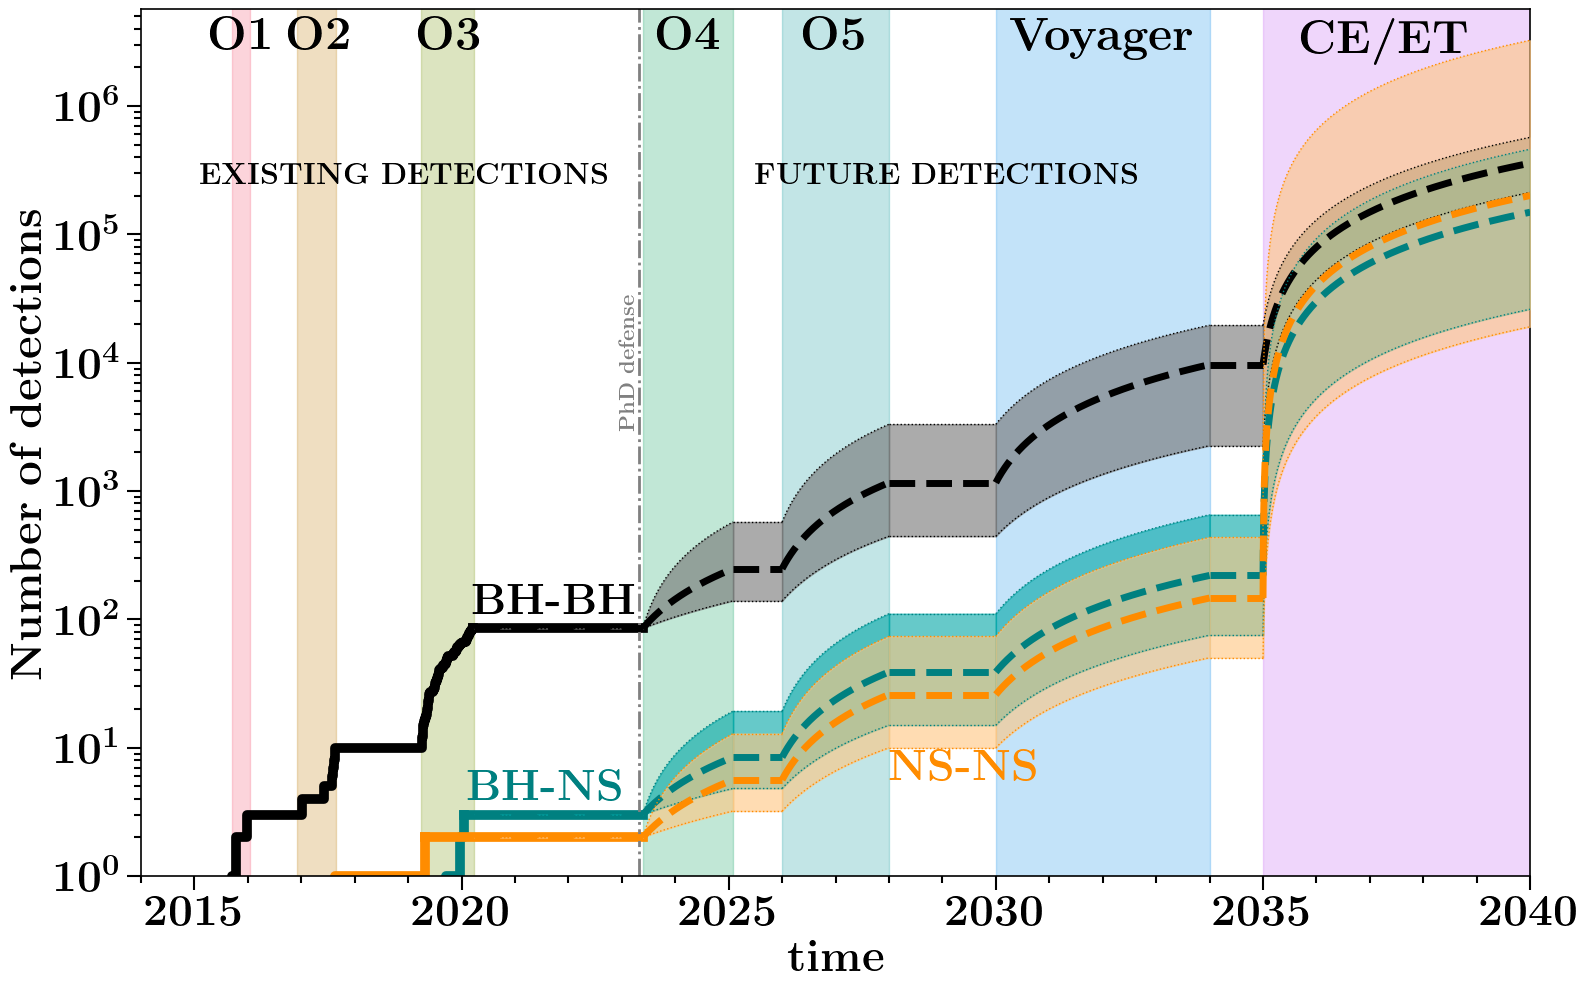

In [261]:
f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))

# DCO
DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
DCOnumberslist_up = [numbers_BBH_up, numbers_BHNS_up, numbers_BNS_up]
DCOnumberslist_down = [numbers_BBH_down, numbers_BHNS_down, numbers_BNS_down]

plotUncertainty=True
print_phd_date=True
print_today=False


for ind_DCO, DCOdetections in enumerate(detectionlist):
    cumhist_stop_year(data=np.asarray(DCOdetections), ax=axe, stop_year=O4begin, lw=7, c=DCOcolors[ind_DCO])
#     cumhist(data=np.asarray(DCOdetections), c=DCOcolors[ind_DCO], lw=7)


for ind_d, line in enumerate(dates[:-1]):
    x_ = np.linspace(dates[ind_d], dates[ind_d+1], 1000)
    
    for ind_DCO, DCOlist in enumerate(DCOnumberslist):
        y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d+1], 1000)
        axe.plot(x_, y_, c=DCOcolors[ind_DCO], lw=5, ls='--', zorder=10)
        
        if plotUncertainty:
            y_up = np.linspace(DCOnumberslist_up[ind_DCO][ind_d], DCOnumberslist_up[ind_DCO][ind_d+1], 1000)
            y_down = np.linspace(DCOnumberslist_down[ind_DCO][ind_d], DCOnumberslist_down[ind_DCO][ind_d+1], 1000)

            axe.fill_between(x_, y1=y_down, y2=y_up, color=DCOcolors_lighter[ind_DCO], zorder=9, alpha=0.6)
            axe.plot(x_, y_down, c=DCOcolors[ind_DCO], lw=1, ls=':', zorder=10)
            axe.plot(x_, y_up, c=DCOcolors[ind_DCO], lw=1, ls=':', zorder=10)        
        
# fill between detector runs
for ind_d, line in enumerate(all_dates[:-1]):
    if (ind_d%2)==0:
        axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.001, 0.001], y2=[1E8,1E8], alpha=0.3, color=colors[ind_d], zorder=0)
    


    

if print_phd_date:
    ########## print line of Floor's PhD defense##########
    # days passed since beginning of year
    d0 = date(2023, 1, 1)
    d1 = date(2023, 4, 24)
    delta = d1 - d0
    # find phd day, use -1 to correct for that it starts at 0 
    phd_day = 2023  + (delta.days-1)/356.
    x_today = np.linspace(phd_day, phd_day, 100)
    y_today = np.linspace(1, 10*1E6, 100)
    axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
    axe.annotate(r'$\textbf{PhD defense}$', (phd_day,1E4),  fontsize=fs-8, rotation=90, ha='right', va='center', color='gray' )


if print_today:
    ###### SHOW TODAY ########
    # uncomment the following four lines if you want to print a vertical line that shows where "today" is  
    x_today = np.linspace(datetime_today_perc, datetime_today_perc, 100)
    y_today = np.linspace(0, 5*1E6, 100)
    axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
    axe.annotate(r'$\textbf{Today}$', (datetime_today_perc,0.5), xycoords=('data','figure fraction'),  fontsize=fs-3, rotation=90, ha='right', va='center', color='gray' )
    ###############


    
axe.set_ylim(1,5.7*1E6)    
axe.set_yscale('log')

axe.xaxis.set_major_locator(plt.MultipleLocator(5))
axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
axe.set_xlim(2014, 2040)

# plot the GW detector labels in the top
plot_detector_labels(axe=axe)

xlabel =  r'\textbf{time}'
ylabel = r'\textbf{Number of detections}'
axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False, fontsize=fs+8)


# annotate labels for BHBH, BHNS, BNS
axe.annotate(r'$\textbf{BH-BH}$', (2020.2,0.367), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
axe.annotate(r'$\textbf{BH-NS}$', (2020.1,0.18),  xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
axe.annotate(r'$\textbf{NS-NS}$', (2028.0,0.2 ),  xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )

axe.annotate(r'$\textbf{EXISTING DETECTIONS}$',   (2015.1,0.8), xycoords=('data','figure fraction'),  fontsize=fs-2, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
axe.annotate(r'$\textbf{FUTURE DETECTIONS}$'  ,   (2025.5,0.8), xycoords=('data','figure fraction'),  fontsize=fs-2, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )




plt.tight_layout()
if print_phd_date:
    plt.savefig('./GWcatalogSize_thesis.png', dpi=600, transparent=False)
    plt.savefig('./GWcatalogSize_thesis.pdf', transparent=False)    
else:
    plt.savefig('./GWcatalogSize.png', dpi=600, transparent=False)
    plt.savefig('./GWcatalogSize.pdf', transparent=False) 



plt.show()



# Previous code 

In [ ]:

# # GWTC-1, GWTC-2.1, GWTC-3
# BBH_list = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823', 'GW190403_051519', 'GW190408_181802', 'GW190412', 'GW190413_052954', 'GW190413_134308', 'GW190421_213856', 'GW190426_190642', 'GW190503_185404', 'GW190512_180714', 'GW190513_205428', 'GW190514_065416', 'GW190517_055101', 'GW190519_153544', 'GW190521', 'GW190521_074359', 'GW190527_092055', 'GW190602_175927', 'GW190620_030421', 'GW190630_185205', 'GW190701_203306', 'GW190706_222641', 'GW190707_093326', 'GW190708_232457', 'GW190719_215514', 'GW190720_000836', 'GW190725_174728', 'GW190727_060333', 'GW190728_064510', 'GW190731_140936', 'GW190803_022701', 'GW190805_211137', 'GW190814', 'GW190828_063405', 'GW190828_065509', 'GW190910_112807', 'GW190915_235702', 'GW190916_200658', 'GW190917_114630', 'GW190924_021846', 'GW190925_232845', 'GW190926_050336', 'GW190929_012149', 'GW190930_133541', 'GW191103_012549', 'GW191105_143521', 'GW191109_010717', 'GW191113_071753', 'GW191126_115259', 'GW191127_050227', 'GW191129_134029', 'GW191204_110529', 'GW191204_171526', 'GW191215_223052', 'GW191216_213338', 'GW191222_033537', 'GW191230_180458', 'GW200112_155838', 'GW200128_022011', 'GW200129_065458', 'GW200202_154313', 'GW200208_130117', 'GW200208_222617', 'GW200209_085452', 'GW200210_092255', 'GW200216_220804', 'GW200219_094415', 'GW200220_061928', 'GW200220_124850', 'GW200224_222234', 'GW200225_060421', 'GW200302_015811', 'GW200306_093714', 'GW200308_173609', 'GW200311_115853', 'GW200316_215756', 'GW200322_091133']

# BNS_list = ['GW170817', 'GW190425']

# BHNS_list = ['GW190426_152155', 'GW190917_114630', 'GW200105', 'GW200115']


# print(len(BBH_list), len(BBH_list)-10)

Movie shows the growth and expected growth of the number of gravitational-wave detections from 2015 to 2040. 
The colors show BH-BH (black lines), BH-NS (green), and NS-NS (orange) detections. Solid lines show current detections, whereas dashed lines shows expected rates (which are still uncertain and depend on the detector configuration, and source properties). 


Data:
in 2015: first BH-BH, and a total of 3 BH-BHs (see GWTC-1 https://arxiv.org/abs/1811.12907)
by the end of 2017: seven more BH-BHs (now a total of 10 BH-BH), and the first NS-NS (source: GWTC-2; https://arxiv.org/abs/2010.14527, updated with GWTC-2.1; https://arxiv.org/abs/2108.01045)
in 2019-2020: 76 more BH-BH, now a total of 86 BH-BH in the catalog, 1 more NS-NS (now a total of 2 NS-NS in the catalog), 3 BH-NS (source GWTC-3 https://arxiv.org/abs/2111.03606)
    
This means that the current fraction of each DCO flavor in the total *detections* is approximate: 
BH-BH: 86/91
BH-NS: 3/91
NS-NS: 2/91

We will use these fractions to calculate the detector expectations for observations post O3 
For O4 we use a 1.5 year observing time, and about 2x more detections than O3 (so 180 BBHs= 2x90) based on https://observing.docs.ligo.org/plan/ 
For O5 we use a 2 year observation span, and again about 8x more total detections than O3 (BBH = 8x 90)
For Voyager, we use 4 year timeline, and about 100x more total detections compared to O3  (BBH = 100x 90) on https://arxiv.org/pdf/2001.11173.pdf
For Cosmic Explorer (CE) and  Einstein Telescope (ET) we use a timeline of 5 years, and detection of about 600 000 BBH per year, found from https://arxiv.org/abs/2207.02771



NameError: name 'BBH_list' is not defined

## make full figure in log scale

NameError: name 'numbers_BBH' is not defined

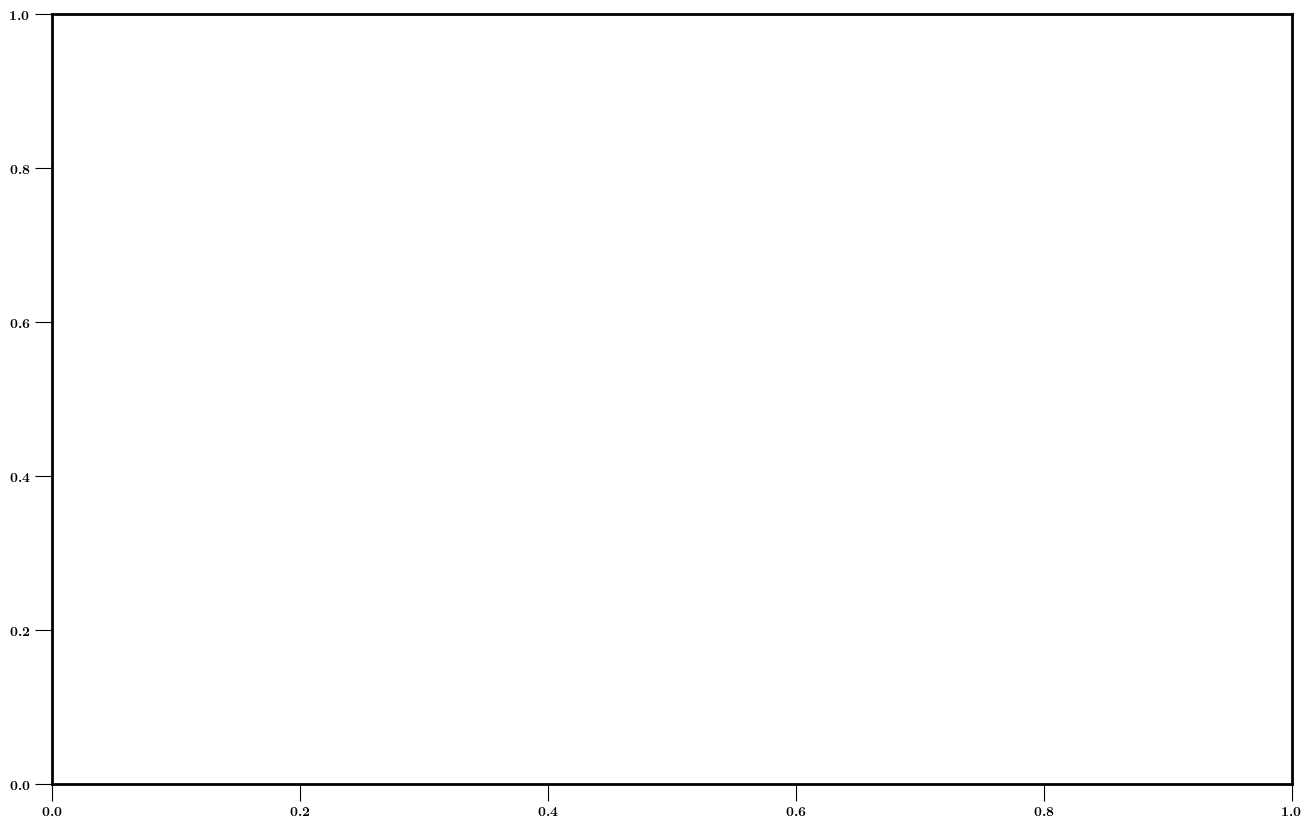

In [87]:
# f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))



# O1begin = 2015+((7)/12) 
# O1end = 2016 +((2)/12) 
# O2begin = 2017 + ((0)/12)
# O2end = 2017 + ((10)/12)
# O3begin = 2019 + ((2)/12)



# ET_CEbegin = 2035
# ET_CEend = 2040

# all_dates = [O1begin, O1end, O2begin, O2end, O3begin, O3end, O4begin, O4end, O5begin, O5end, Voy_begin, Voy_end, ET_CEbegin, ET_CEend]

# DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
# DCOcolors = ['k',  'teal', 'darkorange']
# detectionlist = [strptime_BBHs,  strptime_BHNSs,  strptime_BNSs]

# for ind_DCO, DCOdetections in enumerate(detectionlist):
#     cumhist(data=np.asarray(DCOdetections), c=DCOcolors[ind_DCO], lw=7)


# for ind_d, line in enumerate(dates[:-1]):
#     x_ = np.linspace(dates[ind_d], dates[ind_d+1], 1000)
    
#     for ind_DCO, DCOlist in enumerate(DCOnumberslist):
#         y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d+1], 1000)
#         axe.plot(x_, y_, c=DCOcolors[ind_DCO], lw=5, ls='--', zorder=10)
        
        
    
# ## fix BNS disconecction due to no detections 
# xx = np.linspace(2019.4, 2020.5, 10)
# yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
# axe.plot(xx, yy, c=DCOcolors[2], lw=8, ls='--', zorder=1)
        
# # fill between detector runs
# for ind_d, line in enumerate(all_dates[:-1]):
#     if (ind_d%2)==0:
#         axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.001, 0.001], y2=[1E8,1E8], alpha=0.3, color=colors[ind_d], zorder=0)
    

    

# # # print line today 
# # x_today = np.linspace(today, today, 100)
# # y_today = np.linspace(1, 5*1E6, 100)
# # axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')

# # print line PhD defense
# # days passed since beginning of year
# d0 = date(2023, 1, 1)
# d1 = date(2023, 4, 24)
# delta = d1 - d0
# # find phd day, use -1 to correct for that it starts at 0 
# phd_day = 2023  + (delta.days-1)/356.
# x_today = np.linspace(phd_day, phd_day, 100)
# y_today = np.linspace(1, 10*1E6, 100)
# axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
# axe.annotate(r'$\textbf{PhD defense}$', (phd_day,1E4),  fontsize=fs-8, rotation=90, ha='right', va='center', color='gray' )

    
# axe.set_ylim(1,5.7*1E6)    
# axe.set_yscale('log')

# axe.xaxis.set_major_locator(plt.MultipleLocator(5))
# axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
# axe.set_xlim(2014, 2040)

# # plot the GW detector labels in the top
# plot_detector_labels(axe=axe)

# xlabel =  r'\textbf{time}'
# ylabel = r'\textbf{Number of detections}'
# axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False, fontsize=fs+8)


# # annotate labels for BHBH, BHNS, BNS
# axe.annotate(r'$\textbf{BH-BH}$', (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
# axe.annotate(r'$\textbf{BH-NS}$', (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
# axe.annotate(r'$\textbf{NS-NS}$', (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )



# plt.tight_layout()

# # plt.savefig('./GWcatalogSize.png', dpi=600, transparent=False)
# # plt.savefig('./GWcatalogSize.pdf', transparent=False) 



# plt.show()

NameError: name 'ind_sy' is not defined

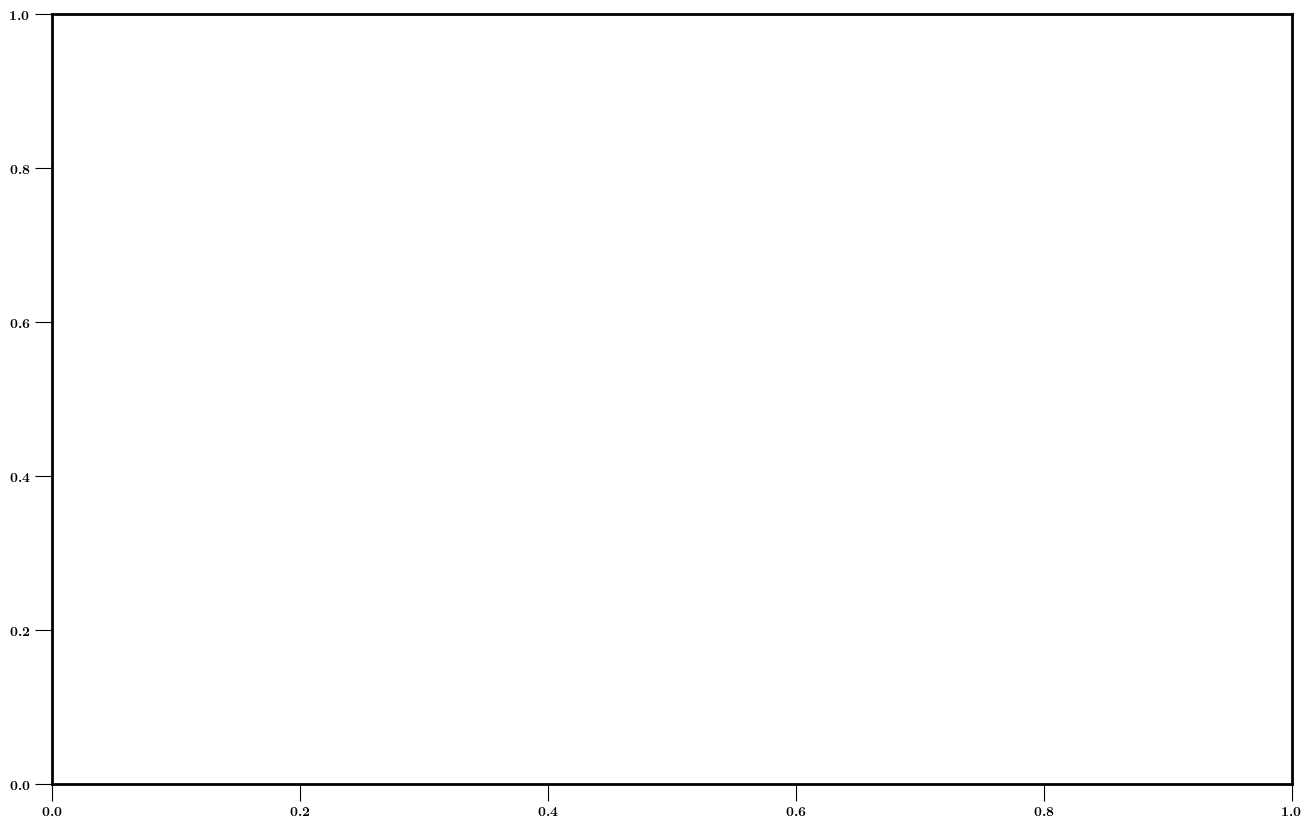

In [250]:

# DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
# DCOnumberslist_up = [numbers_BBH_up, numbers_BHNS_up, numbers_BNS_up]
# DCOnumberslist_down = [numbers_BBH_down, numbers_BHNS_down, numbers_BNS_down]

# DCOcolors = ['k',  'teal', 'darkorange']
# detectionlist = [strptime_BBHs,  strptime_BHNSs,  strptime_BNSs]

# DCOnumberslist_up = [numbers_BBH_up, numbers_BHNS_up, numbers_BNS_up]
# DCOnumberslist_down = [numbers_BBH_down, numbers_BHNS_down, numbers_BNS_down]

plotUncertainty=True



total = 200 
# for ind_sy, stop_year in enumerate([2025, 2030, 2040]):
stop_year=2040
f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))


print('at figure %s out of %s. Stopping this plot at year %s'%(ind_sy+1, total, stop_year))
y_max_all = []

for ind_DCO, DCOdetections in enumerate(detectionlist):
    y_max = cumhist_stop_year(data=np.asarray(DCOdetections), ax=axe, c=DCOcolors[ind_DCO], lw=7, stop_year=stop_year)
    y_max_all.append(y_max)



mask_stop_year = np.asarray(dates[:-1])< stop_year

if np.sum(mask_stop_year)>=1:
    items_ind = len(np.asarray(dates[:-1])[mask_stop_year])
    for ind_d, line in enumerate(np.asarray(dates[:-1])[mask_stop_year]):


        for ind_DCO, DCOlist in enumerate(DCOnumberslist):

            # if we are only plotting the partial line, because we stop plot before end of line
            # then calculate the slope, and the line begin and end points
            if ind_d+1==items_ind:
                x_ = np.linspace(dates[ind_d], stop_year, 1000)
                dy_rate = (DCOlist[ind_d+1]-DCOlist[ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                dy = dy_rate * (stop_year-dates[ind_d])
                y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d]+dy, 1000)


                if plotUncertainty:
#                     x_ = np.linspace(dates[ind_d], stop_year, 1000)
                    dy_rate = (DCOnumberslist_up[ind_DCO][ind_d+1]-DCOnumberslist_up[ind_DCO][ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                    dy = dy_rate * (stop_year-dates[ind_d])
                    y_up = np.linspace(DCOnumberslist_up[ind_DCO][ind_d], DCOnumberslist_up[ind_DCO][ind_d]+dy, 1000)
                    del dy_rate
                    del dy 

                    dy_rate = (DCOnumberslist_down[ind_DCO][ind_d+1]-DCOnumberslist_down[ind_DCO][ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                    dy = dy_rate * (stop_year-dates[ind_d])
                    y_down = np.linspace(DCOnumberslist_down[ind_DCO][ind_d], DCOnumberslist_down[ind_DCO][ind_d]+dy, 1000)                    
                    del dy_rate
                    del dy 

            # otherwise just plot the whole line 
            else:
                x_ = np.linspace(dates[ind_d], dates[ind_d+1], 1000)
                y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d+1], 1000)

                if plotUncertainty:
                    y_up = np.linspace(DCOnumberslist_up[ind_DCO][ind_d], DCOnumberslist_up[ind_DCO][ind_d+1], 1000)
                    y_down = np.linspace(DCOnumberslist_down[ind_DCO][ind_d], DCOnumberslist_down[ind_DCO][ind_d+1], 1000)


            # we know the data before today is 100% real, so show for all date before today a solid line
            mask_dates_before_today = (x_<=today)
            axe.plot(x_[mask_dates_before_today], y_[mask_dates_before_today], c=DCOcolors[ind_DCO], lw=7, ls='-', zorder=10)
            # now plot the remaining rate
            axe.plot(x_, y_, c=DCOcolors[ind_DCO], lw=5, ls='--', zorder=10)
            # add the uncertainty
            if plotUncertainty:
                axe.fill_between(x_, y1=y_down, y2=y_up, color=DCOcolors_lighter[ind_DCO], zorder=9, alpha=0.6)
                axe.plot(x_, y_down, c=DCOcolors[ind_DCO], lw=1, ls=':', zorder=10)
                axe.plot(x_, y_up, c=DCOcolors[ind_DCO], lw=1, ls=':', zorder=10)

            y_max_all.append(y_[-1])
            if plotUncertainty:
                y_max_all.append(y_down[-1])




    ## fix BNS disconecction due to no detections 
    xx = np.linspace(2019.4, 2020.5, 10)
    yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
    axe.plot(xx, yy, c=DCOcolors[2], lw=7, ls='-', zorder=1)

    ## fix BHNS disconecction due to no detections 
    xx = np.linspace(2020.2, 2020.5, 10)
    yy = np.linspace(numbers_BHNS[0], numbers_BHNS[0], 10)
    axe.plot(xx, yy, c=DCOcolors[1], lw=7, ls='-', zorder=1)


# update the max y-value, to scale the y-axis later 
maxx_ = np.max(y_max_all)
max_yvalue = np.max([5, maxx_])


# fill between detector runs
for ind_d, line in enumerate(all_dates[:-1]):
    if (ind_d%2)==0:
        axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.00, 0.00], y2=[2.5*max_yvalue,2.5*max_yvalue], alpha=0.3, color=colors[ind_d], zorder=0)

###### SHOW TODAY ########
# uncomment the following four lines if you want to print a vertical line that shows where "today" is  
#     x_today = np.linspace(today, today, 100)
#     y_today = np.linspace(0, 5*1E6, 100)
#     axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
#     axe.annotate(r'$\textbf{Today}$', (today,0.6), xycoords=('data','figure fraction'),  fontsize=fs-3, rotation=90, ha='right', va='center', color='gray' )
################

axe.set_ylim(0.99,1.5*max_yvalue)    
if stop_year<=2035:
    axe.yaxis.set_major_formatter('{x:,.0f}')
else:
    axe.yaxis.set_major_formatter('{x:2,.0f}')

# set up axis ticks 
axe.xaxis.set_major_locator(plt.MultipleLocator(5))
axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
axe.set_xlim(2014, 2040)

# plot the GW detector labels in the top
plot_detector_labels(axe=axe)

# # print line today 
# x_today = np.linspace(today, today, 100)
# y_today = np.linspace(1, 5*1E6, 100)
# axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')

# print line PhD defense
# days passed since beginning of year
d0 = date(2023, 1, 1)
d1 = date(2023, 4, 24)
delta = d1 - d0
# find phd day, use -1 to correct for that it starts at 0 
phd_day = 2023  + (delta.days-1)/356.
x_today = np.linspace(phd_day, phd_day, 100)
y_today = np.linspace(1, 10*1E6, 100)
axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
axe.annotate(r'$\textbf{PhD defense}$', (phd_day,1E4),  fontsize=fs-8, rotation=90, ha='right', va='center', color='gray' )


axe.set_ylim(1,5.7*1E6)    
axe.set_yscale('log')


xlabel =  r'\textbf{time}'
ylabel = r'\textbf{Number of detections}'
axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False, fontsize=fs+8)


# annotate labels for BHBH, BHNS, BNS
axe.annotate(r'$\textbf{BH-BH}$', (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
axe.annotate(r'$\textbf{BH-NS}$', (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
axe.annotate(r'$\textbf{NS-NS}$', (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )



plt.tight_layout()

plt.savefig('./GWcatalogSize_uncertainty.png', dpi=600, transparent=False)
plt.savefig('./GWcatalogSize_uncertainty.pdf', transparent=False) 
plt.show()
plt.close()



## add a line that shows PhD thesis: 

# only observations 

In [ ]:
f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))



all_dates = [O1begin, O1end, O2begin, O2end, O3begin, O3end, O4begin, O4end, O5begin, O5end, Voy_begin, Voy_end, ET_CEbegin, ET_CEend]

DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
DCOcolors = ['k',  'teal', 'darkorange']
detectionlist = [strptime_BBHs,  strptime_BHNSs,  strptime_BNSs]

for ind_DCO, DCOdetections in enumerate(detectionlist):
    cumhist(data=np.asarray(DCOdetections), c=DCOcolors[ind_DCO], lw=7)

    
## fix BNS disconecction due to no detections 
xx = np.linspace(2019.4, 2020.5, 10)
yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
axe.plot(xx, yy, c=DCOcolors[2], lw=8, ls='--', zorder=1)
        
# fill between detector runs
for ind_d, line in enumerate(all_dates[:-1]):
    if (ind_d%2)==0:
        axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.001, 0.001], y2=[1E8,1E8], alpha=0.3, color=colors[ind_d], zorder=0)
    

    

# print line today 
# x_today = np.linspace(today, today, 100)
# y_today = np.linspace(1, 5*1E6, 100)
# axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')

    
    
axe.set_ylim(1,5*1E6)    
axe.set_yscale('log')

axe.xaxis.set_major_locator(plt.MultipleLocator(5))
axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
axe.set_xlim(2014, 2040)

# plot the GW detector labels in the top
plot_detector_labels(axe=axe)


xlabel =  r'\textbf{time}'
ylabel = r'\textbf{Size of catalog}'
axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False, fontsize=fs+8)


plt.tight_layout()

plt.savefig('./GWcatalogSize_onlyObservations.png', dpi=600, transparent=False)
# plt.savefig('./GWcatalogSize_onlyObservations.pdf', transparent=False) 



plt.show()

# make plots for movie

# Main code: make a loop of images to construct a movie / gif 

In [251]:

# DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
# DCOcolors = ['k',  'teal', 'darkorange']
# detectionlist = [strptime_BBHs,  strptime_BHNSs,  strptime_BNSs]



total = 200 
for ind_sy, stop_year in enumerate(np.linspace(2015, 2040, total)):
    f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))


    print('at figure %s out of %s. Stopping this plot at year %s'%(ind_sy+1, total, stop_year))
    y_max_all = []
    
    for ind_DCO, DCOdetections in enumerate(detectionlist):
        y_max = cumhist_stop_year(data=np.asarray(DCOdetections), ax=axe, c=DCOcolors[ind_DCO], lw=7, stop_year=stop_year)
        y_max_all.append(y_max)


    mask_stop_year = np.asarray(dates[:-1])< stop_year

    if np.sum(mask_stop_year)>=1:
        items_ind = len(np.asarray(dates[:-1])[mask_stop_year])
        for ind_d, line in enumerate(np.asarray(dates[:-1])[mask_stop_year]):
            

            for ind_DCO, DCOlist in enumerate(DCOnumberslist):
                
                # if we are only plotting the partial line, because we stop plot before end of line
                # then calculate the slope, and the line begin and end points
                if ind_d+1==items_ind:
                    x_ = np.linspace(dates[ind_d], stop_year, 1000)
                    dy_rate = (DCOlist[ind_d+1]-DCOlist[ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                    dy = dy_rate * (stop_year-dates[ind_d])
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d]+dy, 1000)
                # otherwise just plot the whole line 
                else:
                    x_ = np.linspace(dates[ind_d], dates[ind_d+1], 1000)
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d+1], 1000)
                
                mask_dates_before_today = (x_<=today)

                axe.plot(x_[mask_dates_before_today], y_[mask_dates_before_today], c=DCOcolors[ind_DCO], lw=7, ls='-', zorder=10)
                axe.plot(x_, y_, c=DCOcolors[ind_DCO], lw=5, ls='--', zorder=10)
                
                y_max_all.append(y_[-1])


        ## fix BNS disconecction due to no detections 
        xx = np.linspace(2019.4, 2020.5, 10)
        yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[2], lw=7, ls='-', zorder=1)
        
        ## fix BHNS disconecction due to no detections 
        xx = np.linspace(2020.2, 2020.5, 10)
        yy = np.linspace(numbers_BHNS[0], numbers_BHNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[1], lw=7, ls='-', zorder=1)
      
        
    # update the max y-value, to scale the y-axis later 
    maxx_ = np.max(y_max_all)
    max_yvalue = np.max([5, maxx_])


    # fill between detector runs
    for ind_d, line in enumerate(all_dates[:-1]):
        if (ind_d%2)==0:
            axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.00, 0.00], y2=[1.5*max_yvalue,1.5*max_yvalue], alpha=0.3, color=colors[ind_d], zorder=0)

    ###### SHOW TODAY ########
    # uncomment the following four lines if you want to print a vertical line that shows where "today" is  
#     x_today = np.linspace(today, today, 100)
#     y_today = np.linspace(0, 5*1E6, 100)
#     axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
#     axe.annotate(r'$\textbf{Today}$', (today,0.6), xycoords=('data','figure fraction'),  fontsize=fs-3, rotation=90, ha='right', va='center', color='gray' )
    ################

    axe.set_ylim(0,1.1*max_yvalue)    
    if stop_year<=2035:
        axe.yaxis.set_major_formatter('{x:,.0f}')
    else:
        axe.yaxis.set_major_formatter('{x:2,.0f}')

    # set up axis ticks 
    axe.xaxis.set_major_locator(plt.MultipleLocator(5))
    axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
    axe.set_xlim(2014, 2040)

    # plot the GW detector labels in the top
    plot_detector_labels(axe=axe)
    
    xlabel =  r'\textbf{time}'
    axe = layoutAxes(axe, nameX=xlabel, nameY=None, setMinor=False, fontsize=fs+8)

    # annotate labels for BHBH, BHNS, BNS
    axe.annotate(r'$\textbf{BH-BH}$', (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
    axe.annotate(r'$\textbf{BH-NS}$', (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
    axe.annotate(r'$\textbf{NS-NS}$', (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )
    
    # add y-label, have to use annotate since otherwise alignment between frames is messed up 
    axe.annotate(r'$\#\textbf{Events}$', (0.012,0.85), xycoords=('figure fraction','figure fraction'),  fontsize=fs+6, rotation=0, ha='left', va='center', color='k' )
#     ylabel = r'\textbf{Number of detections}' # original ylabel name         

    # add credits 
    axe.annotate(r'$\copyright \textbf{Floor Broekgaarden}$', (0.899,0.109), xycoords=('figure fraction','figure fraction'),  fontsize=fs-6, rotation=0, ha='right', va='bottom', color='k' )

    # save to directory for making movie later. 
    plt.savefig('./GWcatalogMovie/GWcatalogSize_%s.png'%ind_sy, dpi=100, transparent=False)
#     plt.show() # this will create a *lot* of figures 
    plt.close()



at figure 1 out of 200. Stopping this plot at year 2015.0
at figure 2 out of 200. Stopping this plot at year 2015.1256281407036
at figure 3 out of 200. Stopping this plot at year 2015.251256281407
at figure 4 out of 200. Stopping this plot at year 2015.3768844221106
at figure 5 out of 200. Stopping this plot at year 2015.502512562814
at figure 6 out of 200. Stopping this plot at year 2015.6281407035176
at figure 7 out of 200. Stopping this plot at year 2015.7537688442212
at figure 8 out of 200. Stopping this plot at year 2015.8793969849246
at figure 9 out of 200. Stopping this plot at year 2016.0050251256282
at figure 10 out of 200. Stopping this plot at year 2016.1306532663316
at figure 11 out of 200. Stopping this plot at year 2016.2562814070352
at figure 12 out of 200. Stopping this plot at year 2016.3819095477386
at figure 13 out of 200. Stopping this plot at year 2016.5075376884422
at figure 14 out of 200. Stopping this plot at year 2016.6331658291458
at figure 15 out of 200. Stop

at figure 117 out of 200. Stopping this plot at year 2029.572864321608
at figure 118 out of 200. Stopping this plot at year 2029.6984924623116
at figure 119 out of 200. Stopping this plot at year 2029.824120603015
at figure 120 out of 200. Stopping this plot at year 2029.9497487437186
at figure 121 out of 200. Stopping this plot at year 2030.0753768844222
at figure 122 out of 200. Stopping this plot at year 2030.2010050251256
at figure 123 out of 200. Stopping this plot at year 2030.3266331658292
at figure 124 out of 200. Stopping this plot at year 2030.4522613065326
at figure 125 out of 200. Stopping this plot at year 2030.5778894472362
at figure 126 out of 200. Stopping this plot at year 2030.7035175879396
at figure 127 out of 200. Stopping this plot at year 2030.8291457286432
at figure 128 out of 200. Stopping this plot at year 2030.9547738693468
at figure 129 out of 200. Stopping this plot at year 2031.0804020100502
at figure 130 out of 200. Stopping this plot at year 2031.20603015

In [ ]:
## Steps to make movie: 
# adjust the python script makeMovie.py to point to your directory with GWcatalog images. (here it is /Users/floorbroekgaarden/Projects/GitHub/Othercode/GWcatalogMovie)
# optional: you can also change the speed/time/number of frames and the name of the movie etc. 
# run the following code:

!python3 makeMovie.py



In [ ]:
lighte

# With Error Bars 

In [253]:

# DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
# DCOcolors = ['k',  'teal', 'darkorange']
# detectionlist = [strptime_BBHs,  strptime_BHNSs,  strptime_BNSs]

# DCOnumberslist_up = [numbers_BBH_up, numbers_BHNS_up, numbers_BNS_up]
# DCOnumberslist_down = [numbers_BBH_down, numbers_BHNS_down, numbers_BNS_down]

plotUncertainty=False



total = 200 
# for ind_sy, stop_year in enumerate([2025, 2030, 2040]):
for ind_sy, stop_year in enumerate(np.linspace(2015, 2040, total)):
    f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))


    print('at figure %s out of %s. Stopping this plot at year %s'%(ind_sy+1, total, stop_year))
    y_max_all = []
    
    for ind_DCO, DCOdetections in enumerate(detectionlist):
        y_max = cumhist_stop_year(data=np.asarray(DCOdetections), ax=axe, c=DCOcolors[ind_DCO], lw=7, stop_year=stop_year)
        y_max_all.append(y_max)

        if stop_year<2021:
            if ind_DCO==0:
                axe.annotate(r'$\textbf{BH-BH: } %s$'%int(y_max), (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
            if ind_DCO==1:
                axe.annotate(r'$\textbf{BH-NS: } %s$'%int(y_max), (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
            if ind_DCO==2:
                axe.annotate(r'$\textbf{NS-NS: } %s$'%int(y_max), (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )


    mask_stop_year = np.asarray(dates[:-1])< stop_year

    if np.sum(mask_stop_year)>=1:
        items_ind = len(np.asarray(dates[:-1])[mask_stop_year])
        for ind_d, line in enumerate(np.asarray(dates[:-1])[mask_stop_year]):
            

            for ind_DCO, DCOlist in enumerate(DCOnumberslist):
                
                # if we are only plotting the partial line, because we stop plot before end of line
                # then calculate the slope, and the line begin and end points
                if ind_d+1==items_ind:
                    x_ = np.linspace(dates[ind_d], stop_year, 1000)
                    dy_rate = (DCOlist[ind_d+1]-DCOlist[ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                    dy = dy_rate * (stop_year-dates[ind_d])
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d]+dy, 1000)
                
                
                    if plotUncertainty:
    #                     x_ = np.linspace(dates[ind_d], stop_year, 1000)
                        dy_rate = (DCOnumberslist_up[ind_DCO][ind_d+1]-DCOnumberslist_up[ind_DCO][ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                        dy = dy_rate * (stop_year-dates[ind_d])
                        y_up = np.linspace(DCOnumberslist_up[ind_DCO][ind_d], DCOnumberslist_up[ind_DCO][ind_d]+dy, 1000)
                        del dy_rate
                        del dy 

                        dy_rate = (DCOnumberslist_down[ind_DCO][ind_d+1]-DCOnumberslist_down[ind_DCO][ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                        dy = dy_rate * (stop_year-dates[ind_d])
                        y_down = np.linspace(DCOnumberslist_down[ind_DCO][ind_d], DCOnumberslist_down[ind_DCO][ind_d]+dy, 1000)                    
                        del dy_rate
                        del dy 
                    
                # otherwise just plot the whole line 
                else:
                    x_ = np.linspace(dates[ind_d], dates[ind_d+1], 1000)
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d+1], 1000)
                
                    if plotUncertainty:
                        y_up = np.linspace(DCOnumberslist_up[ind_DCO][ind_d], DCOnumberslist_up[ind_DCO][ind_d+1], 1000)
                        y_down = np.linspace(DCOnumberslist_down[ind_DCO][ind_d], DCOnumberslist_down[ind_DCO][ind_d+1], 1000)
                    
                
                # we know the data before today is 100% real, so show for all date before today a solid line
                mask_dates_before_today = (x_<=today)
                axe.plot(x_[mask_dates_before_today], y_[mask_dates_before_today], c=DCOcolors[ind_DCO], lw=7, ls='-', zorder=10)
                # now plot the remaining rate
                axe.plot(x_, y_, c=DCOcolors[ind_DCO], lw=5, ls='--', zorder=10)
                # add the uncertainty
                if plotUncertainty:
                    axe.fill_between(x_, y1=y_down, y2=y_up, color=DCOcolors_lighter[ind_DCO], zorder=9, alpha=0.8)
                
                
                y_max_all.append(y_[-1])


                
                
                if line == np.asarray(dates[:-1])[mask_stop_year][-1]:
                    # annotate labels for BHBH, BHNS, BNS
                    if ind_DCO==0:
                        axe.annotate(r'$\textbf{BH-BH: } %s$'%int(y_[-1]), (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
                    if ind_DCO==1:
                        axe.annotate(r'$\textbf{BH-NS: } %s$'%int(y_[-1]), (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
                    if ind_DCO==2:
                        axe.annotate(r'$\textbf{NS-NS: } %s$'%int(y_[-1]), (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )

    
            
        ## fix BNS disconecction due to no detections 
        xx = np.linspace(2019.4, 2020.5, 10)
        yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[2], lw=7, ls='-', zorder=1)
        
        ## fix BHNS disconecction due to no detections 
        xx = np.linspace(2020.2, 2020.5, 10)
        yy = np.linspace(numbers_BHNS[0], numbers_BHNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[1], lw=7, ls='-', zorder=1)
      
        
    # update the max y-value, to scale the y-axis later 
    maxx_ = np.max(y_max_all)
    max_yvalue = np.max([5, maxx_])


    # fill between detector runs
    for ind_d, line in enumerate(all_dates[:-1]):
        if (ind_d%2)==0:
            axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.00, 0.00], y2=[1.5*max_yvalue,1.5*max_yvalue], alpha=0.3, color=colors[ind_d], zorder=0)

    ###### SHOW TODAY ########
    # uncomment the following four lines if you want to print a vertical line that shows where "today" is  
#     x_today = np.linspace(today, today, 100)
#     y_today = np.linspace(0, 5*1E6, 100)
#     axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
#     axe.annotate(r'$\textbf{Today}$', (today,0.6), xycoords=('data','figure fraction'),  fontsize=fs-3, rotation=90, ha='right', va='center', color='gray' )
    ################

    axe.set_ylim(0,1.1*max_yvalue)    
    if stop_year<=2035:
        axe.yaxis.set_major_formatter('{x:,.0f}')
    else:
        axe.yaxis.set_major_formatter('{x:2,.0f}')

    # set up axis ticks 
    axe.xaxis.set_major_locator(plt.MultipleLocator(5))
    axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
    axe.set_xlim(2014, 2040)

    # plot the GW detector labels in the top
    plot_detector_labels(axe=axe)
    
    xlabel =  r'\textbf{time}'
    axe = layoutAxes(axe, nameX=xlabel, nameY=None, setMinor=False, fontsize=fs+8)

#     # annotate labels for BHBH, BHNS, BNS
#     axe.annotate(r'$\textbf{BH-BH}$', (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
#     axe.annotate(r'$\textbf{BH-NS}$', (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
#     axe.annotate(r'$\textbf{NS-NS}$', (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )
    
    # add y-label, have to use annotate since otherwise alignment between frames is messed up 
    axe.annotate(r'$\#\textbf{Events}$', (0.010,0.88), xycoords=('figure fraction','figure fraction'),  fontsize=fs+6, rotation=0, ha='left', va='center', color='k' )
#     ylabel = r'\textbf{Number of detections}' # original ylabel name         

    # add credits 
    axe.annotate(r'$\copyright \textbf{Floor Broekgaarden}$', (0.895,0.114), xycoords=('figure fraction','figure fraction'),  fontsize=fs-10, rotation=0, ha='right', va='bottom', color='k' )

    # save to directory for making movie later. 
    plt.savefig('./GWcatalogMovie/GWcatalogSize_withUpdatedCE_%s.png'%ind_sy, dpi=100, transparent=False)
#     plt.show() # this will create a *lot* of figures 
    plt.close()



at figure 1 out of 200. Stopping this plot at year 2015.0
at figure 2 out of 200. Stopping this plot at year 2015.1256281407036
at figure 3 out of 200. Stopping this plot at year 2015.251256281407
at figure 4 out of 200. Stopping this plot at year 2015.3768844221106
at figure 5 out of 200. Stopping this plot at year 2015.502512562814
at figure 6 out of 200. Stopping this plot at year 2015.6281407035176
at figure 7 out of 200. Stopping this plot at year 2015.7537688442212
at figure 8 out of 200. Stopping this plot at year 2015.8793969849246
at figure 9 out of 200. Stopping this plot at year 2016.0050251256282
at figure 10 out of 200. Stopping this plot at year 2016.1306532663316
at figure 11 out of 200. Stopping this plot at year 2016.2562814070352
at figure 12 out of 200. Stopping this plot at year 2016.3819095477386
at figure 13 out of 200. Stopping this plot at year 2016.5075376884422
at figure 14 out of 200. Stopping this plot at year 2016.6331658291458
at figure 15 out of 200. Stop

at figure 117 out of 200. Stopping this plot at year 2029.572864321608
at figure 118 out of 200. Stopping this plot at year 2029.6984924623116
at figure 119 out of 200. Stopping this plot at year 2029.824120603015
at figure 120 out of 200. Stopping this plot at year 2029.9497487437186
at figure 121 out of 200. Stopping this plot at year 2030.0753768844222
at figure 122 out of 200. Stopping this plot at year 2030.2010050251256
at figure 123 out of 200. Stopping this plot at year 2030.3266331658292
at figure 124 out of 200. Stopping this plot at year 2030.4522613065326
at figure 125 out of 200. Stopping this plot at year 2030.5778894472362
at figure 126 out of 200. Stopping this plot at year 2030.7035175879396
at figure 127 out of 200. Stopping this plot at year 2030.8291457286432
at figure 128 out of 200. Stopping this plot at year 2030.9547738693468
at figure 129 out of 200. Stopping this plot at year 2031.0804020100502
at figure 130 out of 200. Stopping this plot at year 2031.20603015

## With Uncertainty (have to go log)?


In [254]:

# DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
# DCOcolors = ['k',  'teal', 'darkorange']
# detectionlist = [strptime_BBHs,  strptime_BHNSs,  strptime_BNSs]

# DCOnumberslist_up = [numbers_BBH_up, numbers_BHNS_up, numbers_BNS_up]
# DCOnumberslist_down = [numbers_BBH_down, numbers_BHNS_down, numbers_BNS_down]

plotUncertainty=True



total = 200 
# for ind_sy, stop_year in enumerate([2025, 2030, 2040]):
for ind_sy, stop_year in enumerate(np.linspace(2015, 2040, total)):
    f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))


    print('at figure %s out of %s. Stopping this plot at year %s'%(ind_sy+1, total, stop_year))
    y_max_all = []
    
    for ind_DCO, DCOdetections in enumerate(detectionlist):
        y_max = cumhist_stop_year(data=np.asarray(DCOdetections), ax=axe, c=DCOcolors[ind_DCO], lw=7, stop_year=stop_year)
        y_max_all.append(y_max)

        if stop_year<2021:
            if ind_DCO==0:
                axe.annotate(r'$\textbf{BH-BH: } %s$'%int(y_max), (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
            if ind_DCO==1:
                axe.annotate(r'$\textbf{BH-NS: } %s$'%int(y_max), (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
            if ind_DCO==2:
                axe.annotate(r'$\textbf{NS-NS: } %s$'%int(y_max), (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )


    mask_stop_year = np.asarray(dates[:-1])< stop_year

    if np.sum(mask_stop_year)>=1:
        items_ind = len(np.asarray(dates[:-1])[mask_stop_year])
        for ind_d, line in enumerate(np.asarray(dates[:-1])[mask_stop_year]):
            

            for ind_DCO, DCOlist in enumerate(DCOnumberslist):
                
                # if we are only plotting the partial line, because we stop plot before end of line
                # then calculate the slope, and the line begin and end points
                if ind_d+1==items_ind:
                    x_ = np.linspace(dates[ind_d], stop_year, 1000)
                    dy_rate = (DCOlist[ind_d+1]-DCOlist[ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                    dy = dy_rate * (stop_year-dates[ind_d])
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d]+dy, 1000)
                
                
                    if plotUncertainty:
    #                     x_ = np.linspace(dates[ind_d], stop_year, 1000)
                        dy_rate = (DCOnumberslist_up[ind_DCO][ind_d+1]-DCOnumberslist_up[ind_DCO][ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                        dy = dy_rate * (stop_year-dates[ind_d])
                        y_up = np.linspace(DCOnumberslist_up[ind_DCO][ind_d], DCOnumberslist_up[ind_DCO][ind_d]+dy, 1000)
                        del dy_rate
                        del dy 

                        dy_rate = (DCOnumberslist_down[ind_DCO][ind_d+1]-DCOnumberslist_down[ind_DCO][ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                        dy = dy_rate * (stop_year-dates[ind_d])
                        y_down = np.linspace(DCOnumberslist_down[ind_DCO][ind_d], DCOnumberslist_down[ind_DCO][ind_d]+dy, 1000)                    
                        del dy_rate
                        del dy 
                    
                # otherwise just plot the whole line 
                else:
                    x_ = np.linspace(dates[ind_d], dates[ind_d+1], 1000)
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d+1], 1000)
                
                    if plotUncertainty:
                        y_up = np.linspace(DCOnumberslist_up[ind_DCO][ind_d], DCOnumberslist_up[ind_DCO][ind_d+1], 1000)
                        y_down = np.linspace(DCOnumberslist_down[ind_DCO][ind_d], DCOnumberslist_down[ind_DCO][ind_d+1], 1000)
                    
                
                # we know the data before today is 100% real, so show for all date before today a solid line
                mask_dates_before_today = (x_<=today)
                axe.plot(x_[mask_dates_before_today], y_[mask_dates_before_today], c=DCOcolors[ind_DCO], lw=7, ls='-', zorder=10)
                # now plot the remaining rate
                axe.plot(x_, y_, c=DCOcolors[ind_DCO], lw=5, ls='--', zorder=10)
                # add the uncertainty
                if plotUncertainty:
                    axe.fill_between(x_, y1=y_down, y2=y_up, color=DCOcolors_lighter[ind_DCO], zorder=9, alpha=0.6)
                    axe.plot(x_, y_down, c=DCOcolors[ind_DCO], lw=1, ls=':', zorder=10)
                    axe.plot(x_, y_up, c=DCOcolors[ind_DCO], lw=1, ls=':', zorder=10)
                
                y_max_all.append(y_[-1])
                if plotUncertainty:
                    y_max_all.append(y_down[-1])


                
                
                if line == np.asarray(dates[:-1])[mask_stop_year][-1]:
                    # annotate labels for BHBH, BHNS, BNS
                    if ind_DCO==0:
                        axe.annotate(r'$\textbf{BH-BH: } %s$'%int(y_[-1]), (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
                    if ind_DCO==1:
                        axe.annotate(r'$\textbf{BH-NS: } %s$'%int(y_[-1]), (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
                    if ind_DCO==2:
                        axe.annotate(r'$\textbf{NS-NS: } %s$'%int(y_[-1]), (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )

    
            
        ## fix BNS disconecction due to no detections 
        xx = np.linspace(2019.4, 2020.5, 10)
        yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[2], lw=7, ls='-', zorder=1)
        
        ## fix BHNS disconecction due to no detections 
        xx = np.linspace(2020.2, 2020.5, 10)
        yy = np.linspace(numbers_BHNS[0], numbers_BHNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[1], lw=7, ls='-', zorder=1)
      
        
    # update the max y-value, to scale the y-axis later 
    maxx_ = np.max(y_max_all)
    max_yvalue = np.max([5, maxx_])


    # fill between detector runs
    for ind_d, line in enumerate(all_dates[:-1]):
        if (ind_d%2)==0:
            axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.00, 0.00], y2=[2.5*max_yvalue,2.5*max_yvalue], alpha=0.3, color=colors[ind_d], zorder=0)

    ###### SHOW TODAY ########
    # uncomment the following four lines if you want to print a vertical line that shows where "today" is  
#     x_today = np.linspace(today, today, 100)
#     y_today = np.linspace(0, 5*1E6, 100)
#     axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
#     axe.annotate(r'$\textbf{Today}$', (today,0.6), xycoords=('data','figure fraction'),  fontsize=fs-3, rotation=90, ha='right', va='center', color='gray' )
    ################

    axe.set_ylim(0.99,1.5*max_yvalue)    
    if stop_year<=2035:
        axe.yaxis.set_major_formatter('{x:,.0f}')
    else:
        axe.yaxis.set_major_formatter('{x:2,.0f}')

    # set up axis ticks 
    axe.xaxis.set_major_locator(plt.MultipleLocator(5))
    axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
    axe.set_xlim(2014, 2040)

    # plot the GW detector labels in the top
    plot_detector_labels(axe=axe)
    
    xlabel =  r'\textbf{time}'
    axe = layoutAxes(axe, nameX=xlabel, nameY=None, setMinor=False, fontsize=fs+8)
    axe.set_yscale('log')
#     # annotate labels for BHBH, BHNS, BNS
#     axe.annotate(r'$\textbf{BH-BH}$', (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
#     axe.annotate(r'$\textbf{BH-NS}$', (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
#     axe.annotate(r'$\textbf{NS-NS}$', (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )
    
    # add y-label, have to use annotate since otherwise alignment between frames is messed up 
    axe.annotate(r'$\#\textbf{Events}$', (0.010,0.88), xycoords=('figure fraction','figure fraction'),  fontsize=fs+3, rotation=0, ha='left', va='center', color='k' )
#     ylabel = r'\textbf{Number of detections}' # original ylabel name         

    # add credits 
    axe.annotate(r'$\copyright \textbf{Floor Broekgaarden}$', (0.895,0.114), xycoords=('figure fraction','figure fraction'),  fontsize=fs-10, rotation=0, ha='right', va='bottom', color='k' )

    # save to directory for making movie later. 
    plt.savefig('./GWcatalogMovie/GWcatalogSize_withUncertainty_%s.png'%ind_sy, dpi=100, transparent=False)
#     plt.show() # this will create a *lot* of figures 
    plt.close()



at figure 1 out of 200. Stopping this plot at year 2015.0
at figure 2 out of 200. Stopping this plot at year 2015.1256281407036
at figure 3 out of 200. Stopping this plot at year 2015.251256281407
at figure 4 out of 200. Stopping this plot at year 2015.3768844221106
at figure 5 out of 200. Stopping this plot at year 2015.502512562814
at figure 6 out of 200. Stopping this plot at year 2015.6281407035176
at figure 7 out of 200. Stopping this plot at year 2015.7537688442212
at figure 8 out of 200. Stopping this plot at year 2015.8793969849246
at figure 9 out of 200. Stopping this plot at year 2016.0050251256282
at figure 10 out of 200. Stopping this plot at year 2016.1306532663316
at figure 11 out of 200. Stopping this plot at year 2016.2562814070352
at figure 12 out of 200. Stopping this plot at year 2016.3819095477386
at figure 13 out of 200. Stopping this plot at year 2016.5075376884422
at figure 14 out of 200. Stopping this plot at year 2016.6331658291458
at figure 15 out of 200. Stop

at figure 117 out of 200. Stopping this plot at year 2029.572864321608
at figure 118 out of 200. Stopping this plot at year 2029.6984924623116
at figure 119 out of 200. Stopping this plot at year 2029.824120603015
at figure 120 out of 200. Stopping this plot at year 2029.9497487437186
at figure 121 out of 200. Stopping this plot at year 2030.0753768844222
at figure 122 out of 200. Stopping this plot at year 2030.2010050251256
at figure 123 out of 200. Stopping this plot at year 2030.3266331658292
at figure 124 out of 200. Stopping this plot at year 2030.4522613065326
at figure 125 out of 200. Stopping this plot at year 2030.5778894472362
at figure 126 out of 200. Stopping this plot at year 2030.7035175879396
at figure 127 out of 200. Stopping this plot at year 2030.8291457286432
at figure 128 out of 200. Stopping this plot at year 2030.9547738693468
at figure 129 out of 200. Stopping this plot at year 2031.0804020100502
at figure 130 out of 200. Stopping this plot at year 2031.20603015

In [255]:

# DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
# DCOcolors = ['k',  'teal', 'darkorange']
# detectionlist = [strptime_BBHs,  strptime_BHNSs,  strptime_BNSs]

# DCOnumberslist_up = [numbers_BBH_up, numbers_BHNS_up, numbers_BNS_up]
# DCOnumberslist_down = [numbers_BBH_down, numbers_BHNS_down, numbers_BNS_down]

plotUncertainty=True



total = 200 
# for ind_sy, stop_year in enumerate([2025, 2030, 2040]):
for ind_sy, stop_year in enumerate(np.linspace(2015, 2040, total)):
    f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))


    print('at figure %s out of %s. Stopping this plot at year %s'%(ind_sy+1, total, stop_year))
    y_max_all = []
    
    for ind_DCO, DCOdetections in enumerate(detectionlist):
        y_max = cumhist_stop_year(data=np.asarray(DCOdetections), ax=axe, c=DCOcolors[ind_DCO], lw=7, stop_year=stop_year)
        y_max_all.append(y_max)

        if stop_year<2021:
            if ind_DCO==0:
                axe.annotate(r'$\textbf{BH-BH: } %s$'%int(y_max), (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
            if ind_DCO==1:
                axe.annotate(r'$\textbf{BH-NS: } %s$'%int(y_max), (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
            if ind_DCO==2:
                axe.annotate(r'$\textbf{NS-NS: } %s$'%int(y_max), (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )


    mask_stop_year = np.asarray(dates[:-1])< stop_year

    if np.sum(mask_stop_year)>=1:
        items_ind = len(np.asarray(dates[:-1])[mask_stop_year])
        for ind_d, line in enumerate(np.asarray(dates[:-1])[mask_stop_year]):
            

            for ind_DCO, DCOlist in enumerate(DCOnumberslist):
                
                # if we are only plotting the partial line, because we stop plot before end of line
                # then calculate the slope, and the line begin and end points
                if ind_d+1==items_ind:
                    x_ = np.linspace(dates[ind_d], stop_year, 1000)
                    dy_rate = (DCOlist[ind_d+1]-DCOlist[ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                    dy = dy_rate * (stop_year-dates[ind_d])
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d]+dy, 1000)
                
                
                    if plotUncertainty:
    #                     x_ = np.linspace(dates[ind_d], stop_year, 1000)
                        dy_rate = (DCOnumberslist_up[ind_DCO][ind_d+1]-DCOnumberslist_up[ind_DCO][ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                        dy = dy_rate * (stop_year-dates[ind_d])
                        y_up = np.linspace(DCOnumberslist_up[ind_DCO][ind_d], DCOnumberslist_up[ind_DCO][ind_d]+dy, 1000)
                        del dy_rate
                        del dy 

                        dy_rate = (DCOnumberslist_down[ind_DCO][ind_d+1]-DCOnumberslist_down[ind_DCO][ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                        dy = dy_rate * (stop_year-dates[ind_d])
                        y_down = np.linspace(DCOnumberslist_down[ind_DCO][ind_d], DCOnumberslist_down[ind_DCO][ind_d]+dy, 1000)                    
                        del dy_rate
                        del dy 
                    
                # otherwise just plot the whole line 
                else:
                    x_ = np.linspace(dates[ind_d], dates[ind_d+1], 1000)
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d+1], 1000)
                
                    if plotUncertainty:
                        y_up = np.linspace(DCOnumberslist_up[ind_DCO][ind_d], DCOnumberslist_up[ind_DCO][ind_d+1], 1000)
                        y_down = np.linspace(DCOnumberslist_down[ind_DCO][ind_d], DCOnumberslist_down[ind_DCO][ind_d+1], 1000)
                    
                
                # we know the data before today is 100% real, so show for all date before today a solid line
                mask_dates_before_today = (x_<=today)
                axe.plot(x_[mask_dates_before_today], y_[mask_dates_before_today], c=DCOcolors[ind_DCO], lw=7, ls='-', zorder=10)
                # now plot the remaining rate
                axe.plot(x_, y_, c=DCOcolors[ind_DCO], lw=5, ls='--', zorder=10)
                # add the uncertainty
                if plotUncertainty:
                    axe.fill_between(x_, y1=y_down, y2=y_up, color=DCOcolors_lighter[ind_DCO], zorder=9, alpha=0.8)
                
                
                y_max_all.append(y_[-1])


                
                
                if line == np.asarray(dates[:-1])[mask_stop_year][-1]:
                    # annotate labels for BHBH, BHNS, BNS
                    if ind_DCO==0:
                        axe.annotate(r'$\textbf{BH-BH: } %s$'%int(y_[-1]), (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
                    if ind_DCO==1:
                        axe.annotate(r'$\textbf{BH-NS: } %s$'%int(y_[-1]), (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
                    if ind_DCO==2:
                        axe.annotate(r'$\textbf{NS-NS: } %s$'%int(y_[-1]), (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )

    
            
        ## fix BNS disconecction due to no detections 
        xx = np.linspace(2019.4, 2020.5, 10)
        yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[2], lw=7, ls='-', zorder=1)
        
        ## fix BHNS disconecction due to no detections 
        xx = np.linspace(2020.2, 2020.5, 10)
        yy = np.linspace(numbers_BHNS[0], numbers_BHNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[1], lw=7, ls='-', zorder=1)
      
        
    # update the max y-value, to scale the y-axis later 
    maxx_ = np.max(y_max_all)
    max_yvalue = np.max([5, maxx_])


    # fill between detector runs
    for ind_d, line in enumerate(all_dates[:-1]):
        if (ind_d%2)==0:
            axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.00, 0.00], y2=[1.5*max_yvalue,1.5*max_yvalue], alpha=0.3, color=colors[ind_d], zorder=0)

    ###### SHOW TODAY ########
    # uncomment the following four lines if you want to print a vertical line that shows where "today" is  
#     x_today = np.linspace(today, today, 100)
#     y_today = np.linspace(0, 5*1E6, 100)
#     axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
#     axe.annotate(r'$\textbf{Today}$', (today,0.6), xycoords=('data','figure fraction'),  fontsize=fs-3, rotation=90, ha='right', va='center', color='gray' )
    ################

    axe.set_ylim(0,1.1*max_yvalue)    
    if stop_year<=2035:
        axe.yaxis.set_major_formatter('{x:,.0f}')
    else:
        axe.yaxis.set_major_formatter('{x:2,.0f}')

    # set up axis ticks 
    axe.xaxis.set_major_locator(plt.MultipleLocator(5))
    axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
    axe.set_xlim(2014, 2040)

    # plot the GW detector labels in the top
    plot_detector_labels(axe=axe)
    
    xlabel =  r'\textbf{time}'
    axe = layoutAxes(axe, nameX=xlabel, nameY=None, setMinor=False, fontsize=fs+8)

#     # annotate labels for BHBH, BHNS, BNS
#     axe.annotate(r'$\textbf{BH-BH}$', (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
#     axe.annotate(r'$\textbf{BH-NS}$', (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
#     axe.annotate(r'$\textbf{NS-NS}$', (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )
    
    # add y-label, have to use annotate since otherwise alignment between frames is messed up 
    axe.annotate(r'$\#\textbf{Events}$', (0.010,0.88), xycoords=('figure fraction','figure fraction'),  fontsize=fs+6, rotation=0, ha='left', va='center', color='k' )
#     ylabel = r'\textbf{Number of detections}' # original ylabel name         

    # add credits 
    axe.annotate(r'$\copyright \textbf{Floor Broekgaarden}$', (0.895,0.114), xycoords=('figure fraction','figure fraction'),  fontsize=fs-10, rotation=0, ha='right', va='bottom', color='k' )

    # save to directory for making movie later. 
    plt.savefig('./GWcatalogMovie/GWcatalogSize_UncertaintyLin_%s.png'%ind_sy, dpi=100, transparent=False)
#     plt.show() # this will create a *lot* of figures 
    plt.close()



at figure 1 out of 200. Stopping this plot at year 2015.0
at figure 2 out of 200. Stopping this plot at year 2015.1256281407036
at figure 3 out of 200. Stopping this plot at year 2015.251256281407
at figure 4 out of 200. Stopping this plot at year 2015.3768844221106
at figure 5 out of 200. Stopping this plot at year 2015.502512562814
at figure 6 out of 200. Stopping this plot at year 2015.6281407035176
at figure 7 out of 200. Stopping this plot at year 2015.7537688442212
at figure 8 out of 200. Stopping this plot at year 2015.8793969849246
at figure 9 out of 200. Stopping this plot at year 2016.0050251256282
at figure 10 out of 200. Stopping this plot at year 2016.1306532663316
at figure 11 out of 200. Stopping this plot at year 2016.2562814070352
at figure 12 out of 200. Stopping this plot at year 2016.3819095477386
at figure 13 out of 200. Stopping this plot at year 2016.5075376884422
at figure 14 out of 200. Stopping this plot at year 2016.6331658291458
at figure 15 out of 200. Stop

at figure 117 out of 200. Stopping this plot at year 2029.572864321608
at figure 118 out of 200. Stopping this plot at year 2029.6984924623116
at figure 119 out of 200. Stopping this plot at year 2029.824120603015
at figure 120 out of 200. Stopping this plot at year 2029.9497487437186
at figure 121 out of 200. Stopping this plot at year 2030.0753768844222
at figure 122 out of 200. Stopping this plot at year 2030.2010050251256
at figure 123 out of 200. Stopping this plot at year 2030.3266331658292
at figure 124 out of 200. Stopping this plot at year 2030.4522613065326
at figure 125 out of 200. Stopping this plot at year 2030.5778894472362
at figure 126 out of 200. Stopping this plot at year 2030.7035175879396
at figure 127 out of 200. Stopping this plot at year 2030.8291457286432
at figure 128 out of 200. Stopping this plot at year 2030.9547738693468
at figure 129 out of 200. Stopping this plot at year 2031.0804020100502
at figure 130 out of 200. Stopping this plot at year 2031.20603015

In [ ]:
! python3 makeMovie.py

## Extra 

# O4 plot 

In [259]:
today = datetime.datetime.now()
# days passed since beginning of year
d0 = date(2023, 1, 1)
d1 = date(2023, 5, 24) # 24 may = begin O4 
delta = d1 - d0
# find today, use -1 to correct for that it starts at 0 
O4begin = 2023  + (delta.days-1)/356.
# calculate days until O4
d0 = date(today.year, today.month, today.day)
d1 = date(2023, 5, 24) # 24 may = begin O4 
delta_O4 = d1 - d0
print(delta_O4.days, 'days to O4')
today = today.year  + (delta.days-1)/356.








# DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
# DCOcolors = ['k',  'teal', 'darkorange']
# detectionlist = [strptime_BBHs,  strptime_BHNSs,  strptime_BNSs]



total = 400 

# for ind_sy, stop_year in enumerate([2025]):
for ind_sy, stop_year in enumerate(np.linspace(2015, 2025.05, total)):
    f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))


    print('at figure %s out of %s. Stopping this plot at year %s'%(ind_sy+1, total, stop_year))
    y_max_all = []
    
    for ind_DCO, DCOdetections in enumerate(detectionlist):
        y_max = cumhist_stop_year(data=np.asarray(DCOdetections), ax=axe, c=DCOcolors[ind_DCO], lw=7, stop_year=stop_year)
        y_max_all.append(y_max)

        
        # annotate labels for BHBH, BHNS, BNS
        if stop_year<2021:
            if ind_DCO==0:
                axe.annotate(r'$\textbf{BH-BH: } %s$'%int(y_max), (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
            if ind_DCO==1:
                axe.annotate(r'$\textbf{BH-NS: } %s$'%int(y_max), (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
            if ind_DCO==2:
                axe.annotate(r'$\textbf{NS-NS: } %s$'%int(y_max), (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )



    mask_stop_year = np.asarray(dates[:-1])< stop_year

    if np.sum(mask_stop_year)>=1:
        items_ind = len(np.asarray(dates[:-1])[mask_stop_year])
        for ind_d, line in enumerate(np.asarray(dates[:-1])[mask_stop_year]):
            

            for ind_DCO, DCOlist in enumerate(DCOnumberslist):
                
                # if we are only plotting the partial line, because we stop plot before end of line
                # then calculate the slope, and the line begin and end points
                if ind_d+1==items_ind:
                    x_ = np.linspace(dates[ind_d], stop_year, 1000)
                    dy_rate = (DCOlist[ind_d+1]-DCOlist[ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                    dy = dy_rate * (stop_year-dates[ind_d])
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d]+dy, 1000)
                # otherwise just plot the whole line 
                else:
                    x_ = np.linspace(dates[ind_d], dates[ind_d+1], 1000)
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d+1], 1000)
                
                mask_dates_before_today = (x_<=today)

                axe.plot(x_[mask_dates_before_today], y_[mask_dates_before_today], c=DCOcolors[ind_DCO], lw=7, ls='-', zorder=10)
                axe.plot(x_, y_, c=DCOcolors[ind_DCO], lw=5, ls='--', zorder=10)
                
                y_max_all.append(y_[-1])
                
                if line == np.asarray(dates[:-1])[mask_stop_year][-1]:
                    # annotate labels for BHBH, BHNS, BNS
                    if ind_DCO==0:
                        axe.annotate(r'$\textbf{BH-BH: } %s$'%int(y_[-1]), (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
                    if ind_DCO==1:
                        axe.annotate(r'$\textbf{BH-NS: } %s$'%int(y_[-1]), (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
                    if ind_DCO==2:
                        axe.annotate(r'$\textbf{NS-NS: } %s$'%int(y_[-1]), (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )



        ## fix BNS disconecction due to no detections 
        xx = np.linspace(2019.4, 2020.5, 10)
        yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[2], lw=7, ls='-', zorder=1)
        
        ## fix BHNS disconecction due to no detections 
        xx = np.linspace(2020.2, 2020.5, 10)
        yy = np.linspace(numbers_BHNS[0], numbers_BHNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[1], lw=7, ls='-', zorder=1)
      
        
    # update the max y-value, to scale the y-axis later 
    maxx_ = np.max(y_max_all)
    max_yvalue = np.max([5, maxx_])


    # fill between detector runs
    for ind_d, line in enumerate(all_dates[:-1]):
        if (ind_d%2)==0:
            axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.00, 0.00], y2=[1.5*max_yvalue,1.5*max_yvalue], alpha=0.3, color=colors[ind_d], zorder=0)

    ###### SHOW TODAY ########
    # uncomment the following four lines if you want to print a vertical line that shows where "today" is  
    x_today = np.linspace(today, today, 100)
    y_today = np.linspace(0, 5*1E6, 100)
    axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
    axe.annotate(r'$\textbf{Today}$', (today,0.6), xycoords=('data','figure fraction'),  fontsize=fs-3, rotation=90, ha='right', va='center', color='gray' )
    ###############

    axe.set_ylim(0,1.1*max_yvalue)    
    if stop_year<=2035:
        axe.yaxis.set_major_formatter('{x:,.0f}')
    else:
        axe.yaxis.set_major_formatter('{x:2,.0f}')

    # set up axis ticks 
    axe.xaxis.set_major_locator(plt.MultipleLocator(2))
    axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
    axe.set_xlim(2014, 2026)

    # plot the GW detector labels in the top
    plot_detector_labels_O4(axe=axe)
    
    xlabel =  r'\textbf{time}'
    axe = layoutAxes(axe, nameX=xlabel, nameY=None, setMinor=False, fontsize=fs+8)


    # add y-label, have to use annotate since otherwise alignment between frames is messed up 
    axe.annotate(r'$\textbf{Number of detections}$', (0.02,0.49), xycoords=('figure fraction','figure fraction'),  fontsize=fs+6, rotation=90, ha='left', va='center', color='k' )
#     ylabel = r'\textbf{Number of detections}' # original ylabel name         


    # add days until O4 
    
    axe.annotate(r'$ %s \textbf{ days}$'%delta_O4.days, (0.619,0.74), xycoords=('figure fraction','figure fraction'),  fontsize=fs+16, rotation=0, ha='center', va='center', color='r' )
    axe.annotate(r'$\textbf{until O4!!}$', (0.619,0.69), xycoords=('figure fraction','figure fraction'),  fontsize=fs+16, rotation=0, ha='center', va='center', color='r' )


    # add credits 
    axe.annotate(r'$\copyright \textbf{Floor Broekgaarden}$', (0.883,0.116), xycoords=('figure fraction','figure fraction'),  fontsize=fs-8, rotation=90, ha='right', va='bottom', color='k' )
    
    # save to directory for making movie later. 
    plt.savefig('./GWcatalogMovie/O4GWcatalogSize_%s.png'%ind_sy, dpi=100, transparent=False)
#     plt.show() # this will create a *lot* of figures 
    plt.close()

# plt.show()

55 days to O4
at figure 1 out of 400. Stopping this plot at year 2015.0
at figure 2 out of 400. Stopping this plot at year 2015.025187969925
at figure 3 out of 400. Stopping this plot at year 2015.0503759398496
at figure 4 out of 400. Stopping this plot at year 2015.0755639097745
at figure 5 out of 400. Stopping this plot at year 2015.1007518796991
at figure 6 out of 400. Stopping this plot at year 2015.125939849624
at figure 7 out of 400. Stopping this plot at year 2015.151127819549
at figure 8 out of 400. Stopping this plot at year 2015.1763157894736
at figure 9 out of 400. Stopping this plot at year 2015.2015037593985
at figure 10 out of 400. Stopping this plot at year 2015.2266917293234
at figure 11 out of 400. Stopping this plot at year 2015.251879699248
at figure 12 out of 400. Stopping this plot at year 2015.277067669173
at figure 13 out of 400. Stopping this plot at year 2015.3022556390977
at figure 14 out of 400. Stopping this plot at year 2015.3274436090226
at figure 15 out o

at figure 118 out of 400. Stopping this plot at year 2017.946992481203
at figure 119 out of 400. Stopping this plot at year 2017.9721804511278
at figure 120 out of 400. Stopping this plot at year 2017.9973684210527
at figure 121 out of 400. Stopping this plot at year 2018.0225563909773
at figure 122 out of 400. Stopping this plot at year 2018.0477443609022
at figure 123 out of 400. Stopping this plot at year 2018.0729323308271
at figure 124 out of 400. Stopping this plot at year 2018.0981203007518
at figure 125 out of 400. Stopping this plot at year 2018.1233082706767
at figure 126 out of 400. Stopping this plot at year 2018.1484962406014
at figure 127 out of 400. Stopping this plot at year 2018.1736842105263
at figure 128 out of 400. Stopping this plot at year 2018.1988721804512
at figure 129 out of 400. Stopping this plot at year 2018.2240601503759
at figure 130 out of 400. Stopping this plot at year 2018.2492481203008
at figure 131 out of 400. Stopping this plot at year 2018.2744360

at figure 234 out of 400. Stopping this plot at year 2020.868796992481
at figure 235 out of 400. Stopping this plot at year 2020.893984962406
at figure 236 out of 400. Stopping this plot at year 2020.9191729323309
at figure 237 out of 400. Stopping this plot at year 2020.9443609022555
at figure 238 out of 400. Stopping this plot at year 2020.9695488721804
at figure 239 out of 400. Stopping this plot at year 2020.9947368421053
at figure 240 out of 400. Stopping this plot at year 2021.01992481203
at figure 241 out of 400. Stopping this plot at year 2021.045112781955
at figure 242 out of 400. Stopping this plot at year 2021.0703007518796
at figure 243 out of 400. Stopping this plot at year 2021.0954887218045
at figure 244 out of 400. Stopping this plot at year 2021.1206766917294
at figure 245 out of 400. Stopping this plot at year 2021.145864661654
at figure 246 out of 400. Stopping this plot at year 2021.171052631579
at figure 247 out of 400. Stopping this plot at year 2021.1962406015036

at figure 350 out of 400. Stopping this plot at year 2023.7906015037593
at figure 351 out of 400. Stopping this plot at year 2023.8157894736842
at figure 352 out of 400. Stopping this plot at year 2023.840977443609
at figure 353 out of 400. Stopping this plot at year 2023.8661654135337
at figure 354 out of 400. Stopping this plot at year 2023.8913533834586
at figure 355 out of 400. Stopping this plot at year 2023.9165413533833
at figure 356 out of 400. Stopping this plot at year 2023.9417293233082
at figure 357 out of 400. Stopping this plot at year 2023.966917293233
at figure 358 out of 400. Stopping this plot at year 2023.9921052631578
at figure 359 out of 400. Stopping this plot at year 2024.0172932330827
at figure 360 out of 400. Stopping this plot at year 2024.0424812030076
at figure 361 out of 400. Stopping this plot at year 2024.0676691729323
at figure 362 out of 400. Stopping this plot at year 2024.0928571428572
at figure 363 out of 400. Stopping this plot at year 2024.11804511

## Extra:

Get data from Nitz 

In [ ]:
import pandas as pd
import sys
import h5py as h5



fpath = '/Users/floorbroekgaarden/Downloads/4-OGC_small.hdf'

fdata = h5.File(fpath)


pastro = fdata ['pastro'][:]
ifar = fdata ['ifar'][:]
# mask events with p_astro>=0.5 or ifar >100 as per table 3 in 4-OGC 
mask_pastro = ((pastro>=0.5)| (ifar>100))
print(fdata['mass1'][()][mask_pastro])
print(fdata['mass2'][()][mask_pastro])
print(len(fdata['pastro'][()][mask_pastro]))


r1 = h5.File(fpath,'r')
pastro = r1['pastro'][:]
ifar = r1['ifar'][:]
# mask events with p_astro>=0.5 or ifar >100 as per table 3 in 4-OGC 
mask_pastro = ((pastro>=0.5)| (ifar>100))
print(np.sum(mask_pastro))
a = r1['name'][:][mask_pastro]
b = r1['mass1'][:][mask_pastro]
c = r1['mass2'][:][mask_pastro]
d = r1['pastro'][:][mask_pastro]
e = r1['spin1z'][:][mask_pastro]
f = r1['spin2z'][:][mask_pastro]
r1.close()
table=np.array([a,b,c,d,e,f])
table2=table.transpose()
np.savetxt('/Users/floorbroekgaarden/Downloads/4-OGC_small_masses_final.txt',table2,delimiter='\t', fmt='%s')